In [1]:
import os
import time
import datetime
import itertools
import cartopy
import matplotlib

import numpy as np
import pandas as pd
import rsfuncs as rs
import seaborn as sns
import geopandas as gp

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from matplotlib.lines import Line2D
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from descartes import PolygonPatch
from itertools import combinations
from collections import OrderedDict 

# from scipy.stats import pearsonr
# from matplotlib.lines import Line2D
# from matplotlib.collections import PatchCollection
# from matplotlib.patches import Polygon
# from mpl_toolkits.basemap import Basemap
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from dateutil.relativedelta import relativedelta
# from shapely.ops import unary_union
# from pandas.plotting import register_matplotlib_converters
# from pandas.tseries.offsets import MonthEnd


# register_matplotlib_converters()
# plt.rc('legend',**{'fontsize':14})

# %load_ext autoreload
# %autoreload 2

# Load shapefiles 

In [2]:
# kaweah shapefile
kaweah = gp.read_file("../shape/kb_rpj.shp")
crs = {"init":"epsg:4326"}
kaweah.crs = crs

# flowlines
flowlines = gp.read_file("../shape/huc8_flow_line_Kaweah.shp")

# Casgem wells within 
casgem = gp.read_file("../shape/wells.shp")

# Alpine watersheds 
sierra_sheds = gp.read_file("../shape/kaweah_watersheds.shp")

# Reservoirs
reservoirs = gp.read_file("../shape/reservoirs.shp")


/Users/aakashahamed/anaconda3/envs/rsenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


# Load water balance data 

In [3]:
# Load preprocessed RS Data (P, R, SM, SWE) generated with 02_P_ET_SM
kawdf = rs.col_to_dt(pd.read_csv("../data/RS_analysis_dat.csv"))

# Inflow via streams, canals, aqueducts, etc 
q_in = rs.col_to_dt(pd.read_csv("../data/c2vsim_inflow_km3.csv"))

# Load ET data processed using crop coefficient method
modkc_et = rs.col_to_dt(pd.read_csv("../data/MODkc.csv"))
modkc_et.index = modkc_et.index + pd.offsets.MonthEnd(0) 

# Load SSEBop ET data
ssebop_et =  rs.col_to_dt(pd.read_csv("../data/ssebop_et.csv"))
ssebop_et.index = ssebop_et.index + pd.offsets.MonthEnd(0) 



In [4]:
# Merge dataframes
kdf1 = pd.merge(kawdf,q_in,left_index = True, right_index = True)
kdf2 = pd.merge(kdf1, modkc_et,left_index = True, right_index = True)
wbdf = pd.merge(kdf2, ssebop_et,left_index = True, right_index = True)

# Sum up the inflow
wbdf['inflow'] = wbdf[["Kaweah","Tule","Deer","White","FKC_tule",'FKC_kaweah']].sum(axis = 1)

# Load Validation data

In [5]:
# C2vsim 
c2vsim = pd.read_csv("../data/C2VSIM_sub18_GWS_km3.csv")
c2vsim_ds = rs.col_to_dt(c2vsim)

# Wells from Sarfaraz


In [6]:
####### TRIPLE COLLOCATION FUNCTIONS #######

def calc_tc_error(x,y,z):
    '''
    calculate errors between triplets
    '''
    e_x = np.sqrt(np.abs(np.mean((x - y) * (x - z))))
    e_y = np.sqrt(np.abs(np.mean((y - x) * (y - z))))
    e_z = np.sqrt(np.abs(np.mean((z - x) * (z - y))))

    return e_x, e_y, e_z

def scale_to_ref(src, ref):
    '''
    scale one dataset to another (mean / std)
    '''
    return ((src - np.nanmean(src)) / np.nanstd(src)) * np.nanstd(ref) + np.nanmean(ref)


def do_tc(df):
    '''
    wrapper for calc_tc_error applied to a df 
    '''
    tc_dict = df.astype(float).to_dict('list')
    combos=itertools.permutations(tc_dict, 3) 

    err_dict = {k:[] for k in tc_dict}

    for idx,i in enumerate(combos):

        x = tc_dict[i[0]]
        y = tc_dict[i[1]]
        z = tc_dict[i[2]]

        y_scaled = scale_to_ref(y,x)
        z_scaled = scale_to_ref(z,x)

        e_x, e_y, e_z = calc_tc_error(x, y_scaled, z_scaled)

        err_dict[i[0]].append(e_x)
        err_dict[i[1]].append(e_y)
        err_dict[i[2]].append(e_z)
        
    return err_dict
    

######## PLOTTING FUNCS #########
def monthly_annual(df,coldict,var):
    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))

    # setup
    fig = plt.figure(figsize = (19,7))
    gs = fig.add_gridspec(1, 2, hspace = 0.7,wspace = 0.55)
    
    # Boxplot
    ax1 = fig.add_subplot(gs[0:1, :1])
    ydf = df.copy()
    ydf.index.shift(5, freq='M')
    ydf.resample("Y").sum().boxplot(ax = ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90, fontsize = 12)
    ax1.set_ylabel("{} (mm)".format(var), size = 16)
    ax1.set_title('Annual Mean', size = 16)
    
    # # Monthly mean plot with errs
    ax2 = fig.add_subplot(gs[0:1, 1:3])
    monthly = df.groupby(df.index.month).mean()
    errs= df.groupby(df.index.month).std()
    
    for k,v in cdict.items():
        ax2.errorbar(monthly.index,monthly[k],capsize=5, color = v, yerr = errs[k])

    labels = [datetime.date(1900, x, 1).strftime('%B') for x in df.groupby(df.index.month).mean().index]
    ax2.set_xticks(ticks = df.groupby(df.index.month).mean().index)
    ax2.set_xticklabels(labels,rotation = 90, fontsize = 14)
    ax2.set_title("Monthly Mean", size = 16)

    plt.style.use('default')
    plt.show()
    
def make_plots(df, coldict, var):
    '''
    for a dataframe of a single variable and a dict mapping col names to datasets, return:
    1) mean annual boxplot, 
    2) mean monthly scatterplot, 
    3) full timeseries, 
    4) correlation plot
    5) Triple collocation error box plot
    '''
    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))

    # setup
    fig = plt.figure(figsize = (19,7))
    gs = fig.add_gridspec(2, 5, hspace = 0.7,wspace = 0.55)
    
    # Boxplot
    ax1 = fig.add_subplot(gs[0:1, :1])
    ydf = df.copy()
    ydf.index.shift(5, freq='M')

    if not var == "ET":
        ydf.resample("Y").sum().boxplot(ax = ax1)
    else:
        ydf.resample("Y").sum().boxplot(ax = ax1, showfliers=False)
        
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90, fontsize = 12)
    ax1.set_ylabel("{} (mm)".format(var), size = 16)
    ax1.set_title('Annual Mean', size = 16)
    
    # # Monthly mean plot with errs
    ax2 = fig.add_subplot(gs[0:1, 1:3])
    monthly = df.groupby(df.index.month).mean()
    errs= df.groupby(df.index.month).std()
    
    for k,v in cdict.items():
        ax2.errorbar(monthly.index,monthly[k],capsize=5, color = v, yerr = errs[k])

    labels = [datetime.date(1900, x, 1).strftime('%B')[:3] for x in df.groupby(df.index.month).mean().index]
    ax2.set_xticks(ticks = df.groupby(df.index.month).mean().index)
    ax2.set_xticklabels(labels,rotation = 90, fontsize = 14)
    ax2.set_title("Monthly Mean", size = 16)

    # Corr mat
    ax3 = fig.add_subplot(gs[0:1, 3:4])
    sns.heatmap(df.corr(),annot=True,fmt=".2f", ax = ax3, vmin = 0, vmax = 1, cmap = sns.diverging_palette(300, 145, s=60, as_cmap=True))
    ax3.set_title('Correlation Matrix', size = 16)
    ax3.tick_params(labelsize=14)
    
    # Tc error    
    ax4 = fig.add_subplot(gs[0:1, 4:5])
    dropcols = [x for x in df.columns if "Reservoir" in x ] # or "Q" in x]
    tcdf = df.drop(dropcols, axis = 1)
    pd.DataFrame.from_dict(do_tc(tcdf.dropna())).boxplot(ax = ax4)
    ax4.set_xticklabels(ax4.get_xticklabels(),rotation = 90, fontsize = 14)
    ax4.set_title('TC error (mm)', size = 16)
    
    plt.tight_layout()
    plt.style.use('default')
    plt.show()

    fig = plt.figure(figsize = (19,7))
    gs = fig.add_gridspec(2, 5, hspace = 0.7,wspace = 0.38)
    # Time series
    ax5 = fig.add_subplot(gs[-1, :-1])
    for k,v in cdict.items():
        df[k].plot(ax = ax5,x_compat=True,color = v)

    ax5.xaxis.set_tick_params(reset=True)
    ax5.xaxis.set_major_locator(mdates.YearLocator(1))
    ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax5.set_xlim([df.index[0],df.index[-1]])
    ax5.set_title("{} Monthly Time Series".format(var), size = 15)
    leg = ax5.legend(loc="lower center", ncol = 6,bbox_to_anchor=(0.5, -0.5),
               fancybox=True,  prop={'size': 15})

    ax5.set_ylabel("{} (mm)".format(var), size = 16)

    plt.tight_layout()

    plt.style.use('default')
    plt.show()

    
def draw_poly(gdf, mpl_map, facecolor = "red",  alpha = 0.3, edgecolor = 'black', lw = 1, fill = True):
    
    '''
    Turns a geopandas gdf of polygons into matplotlib polygon patches for friendly plotting with basemap. 
    
    TODO: Add functionality for multipolys 
    '''
    
    lats = []
    lons = []
    for index, row in gdf.iterrows():
         for pt in list(row['geometry'].exterior.coords): 
            lats.append(pt[1])
            lons.append(pt[0])
    
    x, y = m( lons, lats )
    xy = zip(x,y)
    poly = Polygon(list(xy), fc=facecolor, alpha=alpha, ec = edgecolor ,lw = lw, fill = fill)
    plt.gca().add_patch(poly)


def draw_points(gdf, mpl_map, sizecol = None, color = 'red', alpha = 0.7, edgecolor = None, fill = True):
    '''
    Turns a geopandas gdf of points into matplotlib lat/lon objects for friendly plotting with basemap. 
    '''
    lats = []
    lons = []
    for index, row in gdf.iterrows():
         for pt in list(row['geometry'].coords): 
            lats.append(pt[1])
            lons.append(pt[0])
    
    if sizecol is None:
        sizecol = 0.006
    else:
        sizecol = sizecol.values
    
    m.scatter(lons, lats, latlon=True, s = sizecol, alpha=alpha, c = color, edgecolor = edgecolor)

    
def align_yaxis(axes):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = np.array(axes)
    extrema = np.array([ax.get_ylim() for ax in axes])

    # reset for divide by zero issues
    for i in range(len(extrema)):
        if np.isclose(extrema[i, 0], 0.0):
            extrema[i, 0] = -1
        if np.isclose(extrema[i, 1], 0.0):
            extrema[i, 1] = 1

    # upper and lower limits
    lowers = extrema[:, 0]
    uppers = extrema[:, 1]

    # if all pos or all neg, don't scale
    all_positive = False
    all_negative = False
    if lowers.min() > 0.0:
        all_positive = True

    if uppers.max() < 0.0:
        all_negative = True

    if all_negative or all_positive:
        # don't scale
        return

    # pick "most centered" axis
    res = abs(uppers+lowers)
    min_index = np.argmin(res)

    # scale positive or negative part
    multiplier1 = abs(uppers[min_index]/lowers[min_index])
    multiplier2 = abs(lowers[min_index]/uppers[min_index])

    for i in range(len(extrema)):
        # scale positive or negative part based on which induces valid
        if i != min_index:
            lower_change = extrema[i, 1] * -1*multiplier2
            upper_change = extrema[i, 0] * -1*multiplier1
            if upper_change < extrema[i, 1]:
                extrema[i, 0] = lower_change
            else:
                extrema[i, 1] = upper_change

        # bump by 10% for a margin
        extrema[i, 0] *= 1.1
        extrema[i, 1] *= 1.1

    # set axes limits
    [axes[i].set_ylim(*extrema[i]) for i in range(len(extrema))]
    
    
########## TRENDLINE FUNCTIONS ###########
def filt_df_dates(df,startdate,enddate):
    '''
    Filter the master df between desired dates, return the columns we are interested in 
    TODO: Add columns as arg 
    '''
    
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")

    df_mask = (df.index > start) & (df.index <= end)
    
    rscv = df['cv_ds'][df_mask].values
    rscvws = df['cvws_ds'][df_mask].values
    wells = df['wells_ds_km3'].interpolate(how = 'linear')[df_mask].values
    c2vsim = df['c2vsim_ds'][df_mask].values
    grace = df['grace_mean'][df_mask].values
    
    dat = [rscv,rscvws, c2vsim, wells, grace]
    dat_dict = dict(zip(['HyDRAcv', 'HyDRAcvws', 'C2VSim', 'Wells', 'GRACE'], dat))
    
    return dat_dict

def fit_trend(array):
    '''
    Fit a linear trend to a 1d array, return the function and slope 
    '''
    z = np.polyfit(x=array, y=np.arange(0,len(array)), deg=1)
    p = np.poly1d(z)
    ds_trend = p(array)
    x = np.arange(len(array))
    fit = np.polyfit(x, array, 1)
    fit_fn = np.poly1d(fit)
    annual_slope = (fit_fn(x)[-1] - fit_fn(x)[0]) / 2
    
    return fit_fn,annual_slope

def get_trendlines(date1,date2, df):
    '''given a pd.series or pd.DataFrame, return the linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(df, date1, date2)
    polyfits = {k:fit_trend(v) for k,v in d.items()}
    
    yvals = {}
    for k,v in polyfits.items():
        fit = v[0]
        ynew = fit(xidx)
        yvals[k] = pd.DataFrame(ynew, index = pd.date_range(date1,date2,freq="M"))
        
    return yvals


def get_slopes(date1,date2, df):
    '''given a pd.series or pd.DataFrame, return the slope linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(df, date1, date2)
    polyfits = {k:round(fit_trend(v)[1],1) for k,v in d.items()}
    
    return polyfits

def time_mask_df(df):
    mask = (df.index> "2001-09-30")
    return df.loc[mask]

# Study Area Map

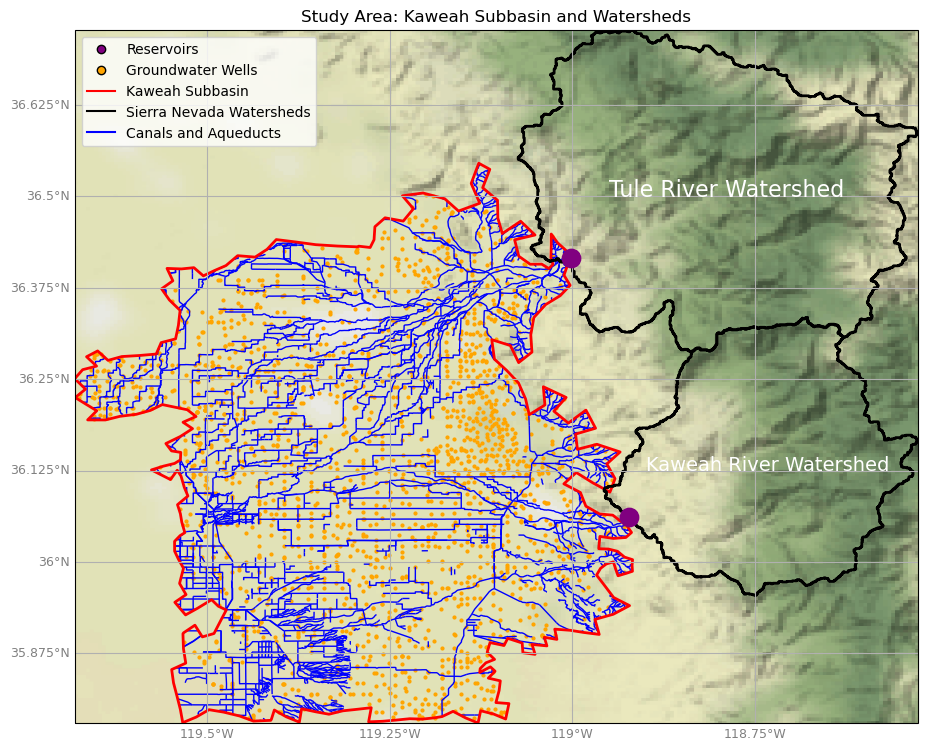

In [56]:
# Read datasets
flowlines = ShapelyFeature(Reader("../shape/huc8_flow_line_Kaweah.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='blue', facecolor = 'none')
kaweah = ShapelyFeature(Reader("../shape/kb_rpj.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='red', facecolor = 'none', linewidth = 2)
watersheds = ShapelyFeature(Reader("../shape/kaweah_watersheds.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='black', facecolor = 'none', linewidth = 2)


# Setup the figure
shapefile = "../shape/stud_area_dissolved.shp"
plt.figure(figsize = (14,9))
ax = plt.axes(projection=ccrs.PlateCarree())

# Get some 
imextent = gp.read_file(shapefile).to_crs(4326).bounds
crs= gp.read_file(shapefile).to_crs(4326)

lllon, lllat = imextent.minx.values[0], imextent.miny.values[0]
urlon, urlat = imextent.maxx.values[0], imextent.maxy.values[0]

# Create a Stamen Terrain instance.
stamen_terrain = cimgt.Stamen('terrain-background')

# Create a GeoAxes in the tile's projection.
gl = ax.gridlines(draw_labels=True)
gl.top_labels= False
gl.right_labels = False

gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,1441))
gl.ylocator = mticker.FixedLocator(np.linspace(0,90,721))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([lllon, urlon, lllat, urlat])

# Add the Stamen data at zoom level 8.
ax.add_image(stamen_terrain, 8)

# Add wells
wells = list(cartopy.io.shapereader.Reader("../shape/wells.shp").geometries())
ax.scatter([point.x for point in wells],
           [point.y for point in wells],
           transform=ccrs.PlateCarree(), color = 'orange', s = 4)

# Add shapefiles
ax.add_feature(flowlines)
ax.add_feature(kaweah)
ax.add_feature(watersheds)

# Add reservoirs
reservoirs = list(cartopy.io.shapereader.Reader("../shape/reservoirs.shp").geometries())
ax.scatter([point.x for point in reservoirs],
           [point.y for point in reservoirs],
           transform=ccrs.PlateCarree(), color = 'purple', s = 175, zorder = 1000)


# Setup legend
handles, labels = plt.gca().get_legend_handles_labels()

# Add legend entries
res_line = Line2D(range(0), range(0), label = 'Reservoirs', color="none", marker='o', markerfacecolor="purple")
well_line = Line2D(range(0), range(0), label = 'Groundwater Wells', color="none", marker='o', markerfacecolor="orange")
ksb_line = Line2D([0], [0], label='Kaweah Subbasin ', color='red')
shed_line = Line2D([0], [0], label='Sierra Nevada Watersheds', color='black')
canals_line = Line2D([0], [0], label='Canals and Aqueducts', color='blue')

# Plot legend 
handles.extend([res_line, well_line, ksb_line,shed_line, canals_line])
plt.legend(handles=handles, loc = 'upper left')

# Annotations to label watersheds
# ax.annotate('peak', xy=(33.5, 2.5), xytext=(40, 4), fontsize=120,
#             arrowprops=dict(facecolor='black'))

ax.text(-118.95, 36.5, "Tule River Watershed", color = 'white', size = 16)
ax.text(-118.9, 36.125, "Kaweah River Watershed", color = 'white', size = 14)

# Set the title
ax.set_title("Study Area: Kaweah Subbasin and Watersheds", size = 12)

# Fix aspect
ax.set_aspect('auto')

plt.show()

(-119.68066859420179, -118.5275)

# Comparison and error analysis

In [8]:
def monthly_annual(df,coldict,var):
    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))

    # setup
    fig = plt.figure(figsize = (13,3))
    gs = fig.add_gridspec(1, 2, hspace = 0.7,wspace = 0.25)
    
    # Boxplot
    ax1 = fig.add_subplot(gs[0:1, :1])
    ydf = df.copy()
    ydf.index.shift(5, freq='M')
    if not var == "ET":
        ydf.resample("Y").sum().boxplot(ax = ax1)
    else:
        ydf.resample("Y").sum().boxplot(ax = ax1, showfliers=False)
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 60, fontsize = 14)
    ax1.set_ylabel("{} (mm)".format(var), size = 16)
    ax1.set_title('Annual Mean', size = 16)
    
    # # Monthly mean plot with errs
    ax2 = fig.add_subplot(gs[0:1, 1:3])
    monthly = df.groupby(df.index.month).mean()
    errs= df.groupby(df.index.month).std()
    
    for k,v in cdict.items():
        ax2.errorbar(monthly.index,monthly[k],capsize=5, color = v, yerr = errs[k], label = k)

    labels = [str(datetime.date(1900, x, 1).strftime('%B'))[:3] for x in df.groupby(df.index.month).mean().index]
    ax2.set_xticks(ticks = df.groupby(df.index.month).mean().index)
    ax2.set_xticklabels(labels,rotation = 90, fontsize = 14)
    ax2.set_title("Monthly Mean", size = 16)

    plt.legend(loc="upper right", ncol = 1,bbox_to_anchor=(1.45, 1.),
               fancybox=True,  prop={'size': 13})
    plt.style.use('default')
    plt.show()
    

# monthly_annual(pdf_cvws / 155000 * 1e6, pcoldict, var = "Precip.")
# monthly_annual(swedf_cvws.diff() / 155000 * 1e6, swecoldict, var = "∆SWE")
# monthly_annual(aetdf_cvws / 155000 * 1e6, aetcoldict, var = "ET")
# monthly_annual(smdf_cvws.diff() / 155000 * 1e6, smcoldict, var = "∆SM / ∆$S_{R}$")

In [9]:
def timeseries(df,coldict,var):
    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))

    fig = plt.figure(figsize = (12,4))
    
    # Boxplot
    ax5 = fig.add_subplot(111)
    
    for k,v in cdict.items():
        df[k].plot(ax = ax5,x_compat=True,color = v)

    ax5.xaxis.set_tick_params(reset=True)
    ax5.xaxis.set_major_locator(mdates.YearLocator(1))
    ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax5.set_xlim([df.index[0],df.index[-1]])
    ax5.set_title("{} Monthly Time Series".format(var), size = 15)
    leg = ax5.legend(loc="lower center", ncol = 6,bbox_to_anchor=(0.5, -0.29),
               fancybox=True,  prop={'size': 15})

    ax5.set_ylabel("{} (mm)".format(var), size = 16)
    plt.show()
    

# timeseries(pdf_cvws / 155000 * 1e6, pcoldict, var = "Precip. (CVWS)")
# timeseries(swedf_cvws.diff() / 155000 * 1e6, swecoldict, var = "∆SWE (CVWS)")
# timeseries(aetdf_cvws / 155000 * 1e6, aetcoldict, var = "ET (CVWS)")
# timeseries(smdf_cvws.diff() / 155000 * 1e6, smcoldict, var = "∆SM / ∆$S_{R}$ (CVWS)")

In [10]:
def corr_err(df,coldict,var):

    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))

    # setup
    fig = plt.figure(figsize = (12,3))
    gs = fig.add_gridspec(1, 2, hspace = 0.7,wspace = 0.15)

    # Corr mat
    ax3 = fig.add_subplot(gs[0:1, 0:1])
    sns.heatmap(df.corr(),annot=True,fmt=".2f", ax = ax3, vmin = 0, vmax = 1, cmap = sns.diverging_palette(300, 145, s=60, as_cmap=True))
    ax3.set_title('Correlation Matrix', size = 16)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90)
    ax3.tick_params(labelsize=14)
    
    # Tc error    
    ax4 = fig.add_subplot(gs[0:1, 1:2])
    dropcols = [x for x in df.columns if "Reservoir" in x ] # or "Q" in x]
    tcdf = df.drop(dropcols, axis = 1)
    pd.DataFrame.from_dict(do_tc(tcdf.dropna())).boxplot(ax = ax4)
    ax4.set_xticklabels(ax4.get_xticklabels(),rotation = 90, fontsize = 14)
    ax4.set_title('TC error (mm)', size = 16)
    
    plt.suptitle(var, size = 20)
    plt.tight_layout()
    plt.style.use('default')
    plt.show()
    
    
# corr_err(pdf_cvws / 155000 * 1e6, pcoldict, var = "Precip. (CVWS)")
# corr_err(swedf_cvws.diff() / 155000 * 1e6, swecoldict, var = "∆SWE (CVWS)")
# corr_err(aetdf_cvws / 155000 * 1e6, aetcoldict, var = "ET (CVWS)")
# corr_err(smdf_cvws.diff() / 155000 * 1e6, smcoldict, var = "∆SM (CVWS)")

In [11]:
wbdf['inflow'] = wbdf[["Kaweah","Tule","Deer","White","FKC_tule",'FKC_kaweah']].sum(axis = 1)

In [14]:
startidx = 0

pcoldict = {'p_prism':'PRISM', 
                'p_gpm':'GPM',  
                'p_dmet':'Daymet',
                'p_psn': "PERSIANN",
                'p_chirps': "CHIRPS"}
pdf = wbdf.loc[:, wbdf.columns.isin(pcoldict.keys())][startidx:-5]
pdf.dropna(axis = 0, how = 'all', inplace = True)
pdf.rename(columns = pcoldict, inplace = True)
pdf = time_mask_df(pdf)

aetcoldict = {'aet_gldas':'GLDAS', 
                'aet_fldas':'FLDAS',  
                'MODkc':"MODkc",
                'aet_tc':'TerraClim',
                'ssebop': "SSEBop",
                'aet_modis': "MOD16"}
aetdf = wbdf.loc[:, wbdf.columns.isin(aetcoldict.keys())][startidx:-5]
aetdf.dropna(axis = 0, how = 'all', inplace = True)
aetdf.rename(columns = aetcoldict, inplace = True)
aetdf = time_mask_df(aetdf)

petcoldict = {'pet_gldas':'GLDAS', 
                'pet_gmet':'Gridmet',  
                'pet_tc':'TerraClim',
                'pet_modis': "MOD16",
                'pet_nldas': "NLDAS"}
petdf = wbdf.loc[:, wbdf.columns.isin(petcoldict.keys())][startidx:-5]
petdf.dropna(axis = 0, how = 'all', inplace = True)
petdf.rename(columns = petcoldict, inplace = True)
petdf = time_mask_df(petdf)

smcoldict = {'sm_smos':'SMOS', 
                'sm_smap':'SMAP',  
                'sm_tc':'TerraClim',
                'sm_gldas': "GLDAS"}
smdf = wbdf.loc[:, wbdf.columns.isin(smcoldict.keys())][startidx:-5]
smdf.dropna(axis = 0, how = 'all', inplace = True)
smdf.rename(columns = smcoldict, inplace = True)
smdf = time_mask_df(smdf)

rcoldict = {'inflow': 'Inflow',
            'r_fldas':'FLDAS',  
            'r_tc':'TerraClim',
            'r_gldas': "GLDAS"}
rdf = wbdf.loc[:, wbdf.columns.isin(rcoldict.keys())][startidx:-5]
rdf.dropna(axis = 0, how = 'all', inplace = True)
rdf.rename(columns = rcoldict, inplace = True)
rdf = time_mask_df(rdf)


<ipython-input-6-691ac4ba90bf>:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


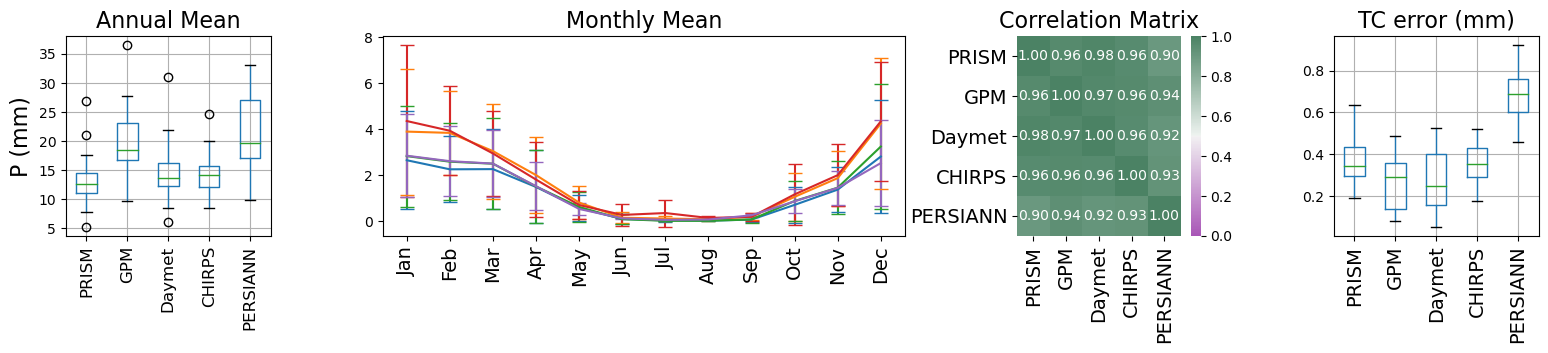

<ipython-input-6-691ac4ba90bf>:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


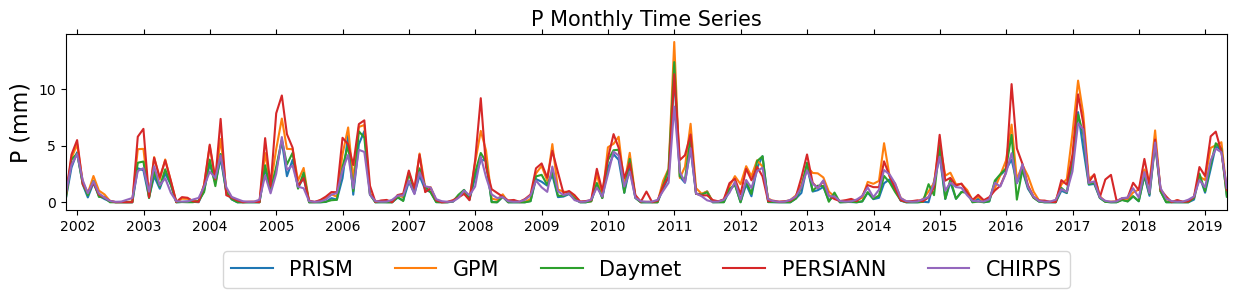

<ipython-input-6-691ac4ba90bf>:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


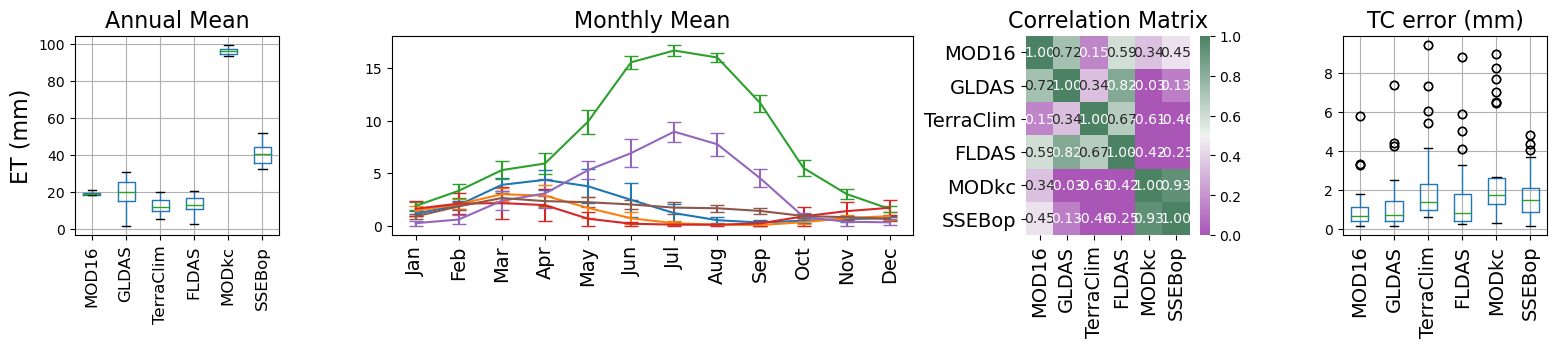

<ipython-input-6-691ac4ba90bf>:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


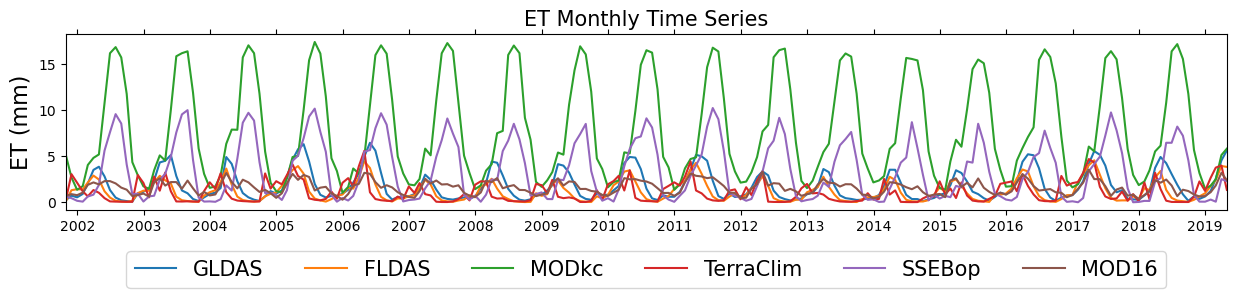

<ipython-input-6-691ac4ba90bf>:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


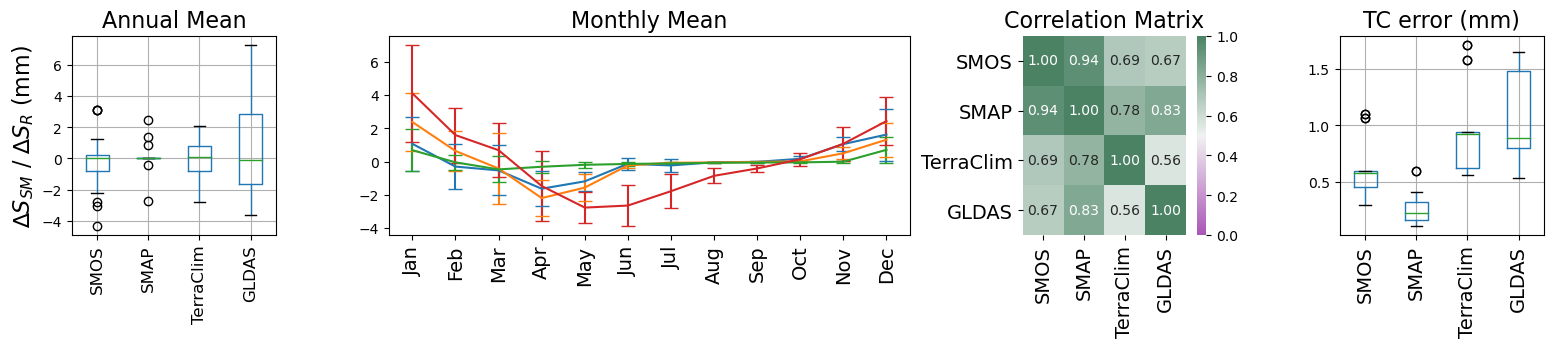

<ipython-input-6-691ac4ba90bf>:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


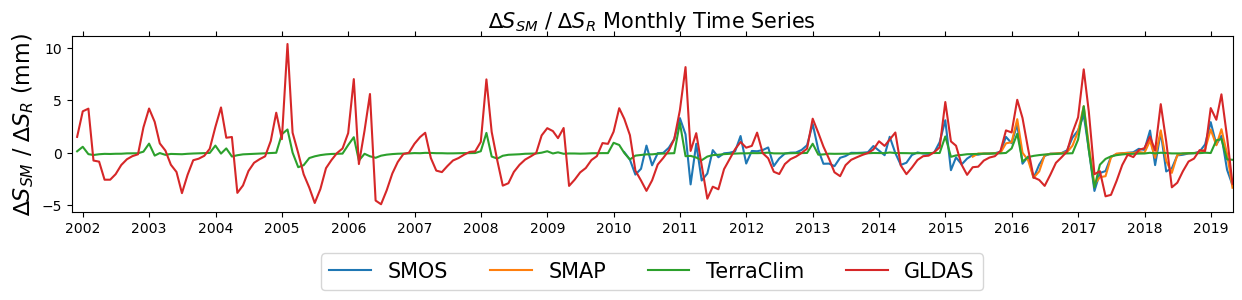

<ipython-input-6-691ac4ba90bf>:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


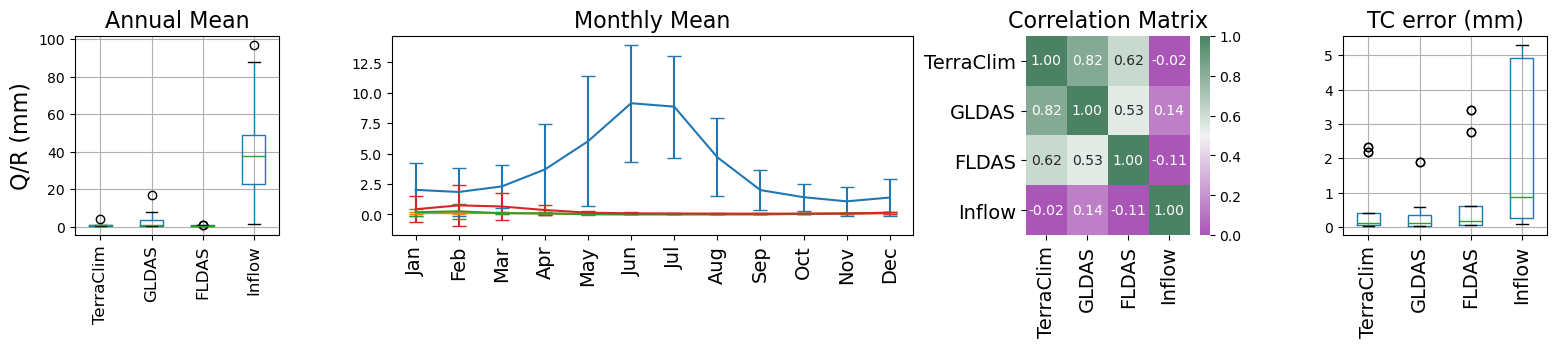

<ipython-input-6-691ac4ba90bf>:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


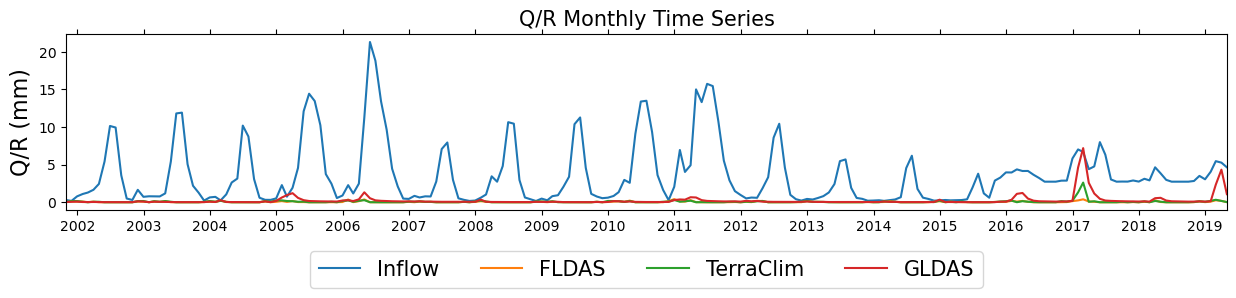

In [15]:
# plt.style.use("default")

make_plots(pdf/ 55000 * 1e6, pcoldict, var = "P")
make_plots(aetdf/ 55000 * 1e6, aetcoldict, var = "ET")
# make_plots(petdf/ 55000 * 1e6, petcoldict, var = "PET")
make_plots(smdf.diff() / 55000 * 1e6, smcoldict, var = "∆$S_{SM}$ / ∆$S_{R}$")
make_plots(rdf/ 55000 * 1e6, rcoldict, var = "Q/R")

In [ ]:
# CVWS Fig S1 

plt.style.use("default")
make_plots(pdf / 155000 * 1e6, pcoldict, var = "P")
plt.style.use("default")
make_plots(swedf_cvws.diff() / 155000 * 1e6, swecoldict, var = "∆$S_{SWE}$")
plt.style.use("default")
make_plots(aetdf_cvws / 155000 * 1e6, aetcoldict, var = "ET")
plt.style.use("default")
make_plots(smdf_cvws.diff() / 155000 * 1e6, smcoldict, var = "∆$S_{SM}$ / ∆$S_{R}$")

In [ ]:
# CVWS Balance

In [ ]:
# CVWS full ensemble list 
plist_cvws = [ "PRISM", "Daymet", 'GPM','CHIRPS',"PERSIANN"]
swelist_cvws = ["Daymet", "FLDAS", "GLDAS", "TerraClim",'UCB LRM','SNODAS']
etlist_cvws = [ 'TerraClim', "FLDAS", 'GLDAS','SSEBop','MODkc','MOD16']
smlist_cvws = ['TerraClim', "GLDAS",'SMOS','SMAP']

combolist_cvws_full = list(itertools.product(*[plist_cvws,swelist_cvws,etlist_cvws,smlist_cvws]))
print("Full Ensemble has {} members".format(str(len(combolist_cvws_full))))

# CVWS LSM ensemble list 
plist_cvws_lsm = [ "PRISM", "Daymet"]
swelist_cvws_lsm = ["Daymet", "FLDAS", "GLDAS", "TerraClim"]
etlist_cvws_lsm = [ 'TerraClim', "FLDAS", 'GLDAS']
smlist_cvws_lsm = ['TerraClim', "GLDAS"]

combolist_cvws_lsm = list(itertools.product(*[plist_cvws_lsm,swelist_cvws_lsm,etlist_cvws_lsm,smlist_cvws_lsm]))
print("LSM-based Ensemble has {} members".format(str(len(combolist_cvws_lsm))))

# CVWS RS ensemble list 
plist_cvws_rs = ['GPM','CHIRPS',"PERSIANN"]
swelist_cvws_rs = ['UCB LRM','SNODAS']
etlist_cvws_rs = ['SSEBop','MODkc','MOD16']
smlist_cvws_rs = ['SMOS','SMAP','TerraClim']

combolist_cvws_rs = list(itertools.product(*[plist_cvws_rs,swelist_cvws_rs,etlist_cvws_rs,smlist_cvws_rs]))
print("RS based Ensemble has {} members".format(str(len(combolist_cvws_rs))))

In [ ]:
# Run the ensembles
calibration_period = 60 # months

# All ensembles
dsens_cvws = []
for p,swe,et,sm in combolist_cvws_full:
    ds = pdf_cvws[p] - aetdf_cvws[et] - rdf_cvws['DWR Qout'] - swedf_cvws[swe].diff() - smdf_cvws['Reservoirs'].diff() - smdf_cvws[sm].diff() 
    dscal = np.cumsum(ds - np.mean(ds[:calibration_period]))
    dsens_cvws.append(dscal)
    
# LSM-based ensemble
dsens_cvws_lsm = []
for p,swe,et,sm in combolist_cvws_lsm:
    ds_lsm = pdf_cvws[p] - aetdf_cvws[et] - rdf_cvws['DWR Qout'] - swedf_cvws[swe].diff() - smdf_cvws['Reservoirs'].diff() - smdf_cvws[sm].diff() 
    ds_lsm_cal = np.cumsum(ds_lsm - np.mean(ds_lsm[:calibration_period]))
    dsens_cvws_lsm.append(ds_lsm_cal)

# RS-based ensemble
dsens_cvws_rs = []
for p,swe,et,sm in combolist_cvws_rs:
    ds_rs = pdf_cvws[p] - aetdf_cvws[et] - rdf_cvws['DWR Qout'] - swedf_cvws[swe].diff() - smdf_cvws['Reservoirs'].diff() - smdf_cvws[sm].diff() 
    ds_rs_cal = np.cumsum(ds_rs - np.mean(ds_rs[:calibration_period]))
    dsens_cvws_rs.append(ds_rs_cal)
    
# Optimal ensemble - LRM / SNODAS mean, ETkc / ssebop mean, SMAP / SMOS / TC mean 
swedf_cvws['rs_swe_mean'] = np.nanmean([swedf_cvws.loc[:,'SNODAS'],swedf_cvws.loc[:,'UCB LRM']], axis = 0)
aetdf_cvws['rs_et_mean'] = np.nanmean([aetdf_cvws.loc[:,'MODkc'],aetdf_cvws.loc[:,'SSEBop'],], axis = 0)
smdf_cvws['rs_sm_mean'] = np.nanmean([smdf_cvws.loc[:,'TerraClim'],smdf_cvws.loc[:,'SMOS'],smdf_cvws.loc[:,'SMAP']], axis = 0)

ds_opt_raw_cvws = pdf_cvws['GPM'] - aetdf_cvws['rs_et_mean'] - rdf_cvws['DWR Qout'] - swedf_cvws['rs_swe_mean'].diff() - smdf_cvws['Reservoirs'].diff() - smdf_cvws['rs_sm_mean'].diff()

ds_opt_cvws = np.cumsum(ds_opt_raw_cvws - np.nanmean(ds_opt_raw_cvws[:calibration_period]))


In [ ]:
# Basic plot
plt.style.use('default')
fig, ax1 = plt.subplots(figsize = (15,5))

# Transparent dummy plot for the mm axis 
ax1.plot(grace.index, grace['grace_mean']/ 150000 * 1e6, color="darkorange",alpha = 0, linewidth = 1.5,label = "Wells") 
ax1.set_ylabel('ΔSgw (mm)')
ax1.grid(None)

# Second axis for Km^3
ax2 = ax1.twinx()  

# Plot all
ax2.plot(np.nanmean(np.vstack(dsens_cvws)), alpha = 0.45, color = 'gray', label = 'all data ensemble members')
ax2.plot(dsens_cvws[0].index,np.nanmean(np.vstack(dsens_cvws), axis = 0),color = 'black', alpha = 1, label = 'all data ensemble mean' , linestyle = "--")

# Plot LSM
ax2.plot(np.nanmean(np.vstack(dsens_cvws_lsm)), alpha = 0.45, color = 'purple', label = 'LSM ensemble members')
ax2.plot(dsens_cvws[0].index,np.nanmean(np.vstack(dsens_cvws_lsm), axis = 0),color = 'purple', alpha = 1, label = 'LSM ensemble mean' , linestyle = "--")

# Plot RS 
ax2.plot(np.nanmean(np.vstack(dsens_cvws_rs)), alpha = 0.45, color = 'red', label = 'RS ensemble members')
ax2.plot(dsens_cvws_rs[0].index,np.nanmean(np.vstack(dsens_cvws_rs), axis = 0),color ='red', alpha = 1, label = 'RS ensemble mean', linestyle = "--")

# Plot optimal
ax2.plot(ds_opt_cvws, label = 'Preferred RS data', linewidth = 2, marker = "+")

# Plot ancillary 
ax2.plot(grace.index, grace['grace_mean'], color="Green",alpha = 1, linewidth = 2, label = "GRACE", marker = 'o') 

# Formatting 
ax2.set_ylabel('ΔSgw ($km^3$)') # Label km3
align_yaxis([ax1,ax2]) # Align the twin axes

# plot all ensembles 
for d in dsens_cvws:
    ax2.plot(d, alpha = 0.03, color = 'gray')

# plot all LSM ensembles
for d in dsens_cvws_lsm:
    ax2.plot(d, alpha = 0.03, color = 'purple')
    
# plot all RS ensembles
for d in dsens_cvws_rs:
    ax2.plot(d, alpha = 0.03, color = 'red')

# Add calibration period label 
ax2.annotate('',verticalalignment="center",xy=(.065, .35), xytext=(calibration_period/ len(ds_opt_cvws.dropna()),.35), xycoords='figure fraction',arrowprops=dict(arrowstyle='<->'),fontsize=20)
ax2.annotate('calibration period',xy=(.01, .37), xytext=(calibration_period/ len(ds_opt_cvws.dropna())/2,.37), xycoords='figure fraction')

# Format year / month ticks 
ax2.xaxis.set_major_locator(mdates.YearLocator())# Major ticks every year.
ax2.xaxis.set_minor_locator(mdates.MonthLocator()) # Minor ticks every month.
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))# Text in the x axis will be displayed in 'YYYY' format.
ax2.set_xlim(ds_opt_cvws.dropna().index[0], ds_opt_cvws.dropna().index[-1] )

plt.legend(loc = 'lower left', ncol = 4)
plt.show()


In [ ]:
# Setup the figure
plt.figure(figsize = (20,6))
G = gridspec.GridSpec(nrows = 3, ncols = 10)

# Plot the basemaps in ax1
ax1 = plt.subplot(G[:, 0:3])

# Initialize the basemap
m = Basemap(ax = ax1,projection='lcc', ellps='WGS84',resolution='i', 
            lat_0=cvws.centroid.y, lon_0=cvws.centroid.x, # Use the geom centroid to center the map 
            width=0.8e6, height=1.2e6)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the shapefiles
draw_poly(cvws, m, alpha = 1, edgecolor = 'black', lw = 1.5, fill = False)
draw_poly(grace_sa, m, alpha = 1, edgecolor = 'red', lw = 1.5, fill = False)
draw_points(outflow,m, alpha = 0.7, sizecol= outflow["q_km3_avg"]*200,  color= 'purple', edgecolor = 'black')
draw_points(reservoirs,m, alpha = 0.7, sizecol= reservoirs["Smean"]*30,  color= 'cyan', edgecolor = 'black')


# Make the first legend (upper left of map)
custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'cyan',markerfacecolor="cyan"),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'purple',markerfacecolor="purple"),
                Line2D([0], [0], color='blue', lw=2)]

leg1 = ax1.legend(custom_lines, ['CVWS boundary', 
                                 "Grace Footprint",
                                 "Reservoirs","$Q_{out}$ stations", "Rivers"], 
                    loc = "upper right",
                    prop={'size':10}, 
                    bbox_to_anchor=(1.2, 1.05))

# Make second legend for reservoir storage
for p in [rp1, rp2, rp3]:
    plt.scatter([], [], c='cyan', alpha=0.5, s=p*30,
                label=str(round(p,2)) + ' km$^3$')

leg2 = ax1.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left', title = "Monghly Avg $S_{res}$");

# Add legends
ax1.add_artist(leg2)
ax1.add_artist(leg1)

# Plot the timeseries
ax2 = plt.subplot(G[:3, 3:])

# Transparent dummy plot for the mm axis 
ax2.plot(grace.index, grace['grace_mean']/ 150000 * 1e6, color="darkorange",alpha = 0, linewidth = 1.5,label = "Wells") 
ax2.set_ylabel('ΔSgw (mm)')
ax2.grid(None)

# Second axis for Km^3
ax3 = ax2.twinx()  

# plot all ensembles 
for d in dsens_cvws:
    ax3.plot(d, alpha = 0.03, color = 'gray')
    
# plot all ensembles
for d in dsens_cvws_rs:
    ax3.plot(d, alpha = 0.03, color = 'red')

# plot all LSM ensembles
for d in dsens_cvws_lsm:
    ax3.plot(d, alpha = 0.03, color = 'purple')
    
# Plot all balance mean
ax3.plot(dsens_cvws_rs[0], alpha = 0.45, color = 'gray', label = 'All Ensembles')
ax3.plot(dsens_cvws[0].index,np.nanmean(np.vstack(dsens_cvws), axis = 0),color = 'black', alpha = 1, label = 'Ensemble mean (all)' , linestyle = "--")

# Plot RS 
ax3.plot(np.nanmean(np.vstack(dsens_cvws_rs)), alpha = 0.45, color = 'red', label = 'RS ensembles')
ax3.plot(dsens_cvws_rs[0].index,np.nanmean(np.vstack(dsens_cvws_rs), axis = 0),color ='red', alpha = 1, label = 'RS ensemble mean', linestyle = "--")

# Plot LSM
ax3.plot(np.nanmean(np.vstack(dsens_cvws_lsm)), alpha = 0.45, color = 'purple', label = 'LSM ensemble members')
ax3.plot(dsens_cvws[0].index,np.nanmean(np.vstack(dsens_cvws_lsm), axis = 0),color = 'purple', alpha = 1, label = 'LSM ensemble mean' , linestyle = "--")

# Plot optimal
ax3.plot(ds_opt_cvws, label = 'Preferred RS data', linewidth = 2, marker = "+")

# Plot ancillary 
ax3.plot(grace.index, grace['grace_mean'], color="Green",alpha = 1, linewidth = 1.5, label = "GRACE", marker = 'v') 

# # Formatting 
ax3.set_ylabel('ΔSgw ($km^3$)') # Label km3
# align_yaxis([ax2,ax3]) # Align the twin axes


# Add calibration period label 
ax2.annotate('',verticalalignment="center",xy=(.0001, .35), xytext=(calibration_period/ len(ds_opt_cvws.dropna())*0.8,.35), xycoords='axes fraction',arrowprops=dict(arrowstyle='<->'),fontsize=20)
ax2.annotate('calibration period',xy=(.001, .37), xytext=(calibration_period/ len(ds_opt_cvws.dropna())/5,.37), xycoords='axes fraction')

# Format year / month ticks 
ax3.xaxis.set_major_locator(mdates.YearLocator())# Major ticks every year.
ax3.xaxis.set_minor_locator(mdates.MonthLocator()) # Minor ticks every month.
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))# Text in the x axis will be displayed in 'YYYY' format.
ax3.set_xlim(ds_opt_cvws.dropna().index[0], ds_opt_cvws.dropna().index[-1] )
ax3.set_ylim(-200,100)

# Title
ax2.set_title("$\Delta S_{gw} = P - ET - Q_{net} - \Delta S_{sm} - \Delta S_{res} - \Delta S_{SWE}$")

# Annotations 
ax3.annotate("Ensemble Members (total = {})".format(str(len(combolist_cvws_full))), xy=(0.25, 0.23), xycoords='axes fraction')
ax3.annotate("SWE: " + ", ".join(swelist_cvws), xy=(0.25,0.18), xycoords='axes fraction')
ax3.annotate("P: " + ", ".join(plist_cvws), xy=(0.25,0.13), xycoords='axes fraction')
ax3.annotate("ET: " + ", ".join(etlist_cvws), xy=(0.25, 0.08), xycoords='axes fraction')
ax3.annotate("SM: " + ", ".join(smlist_cvws), xy=(0.25, 0.03), xycoords='axes fraction')

G.update(wspace=0.4, hspace=0.4) # set the spacing between axes. 

align_yaxis([ax2,ax3])

# plt.tight_layout()
plt.legend()
plt.show()

# CV

In [ ]:
startidx = 58

pcoldict = {'p_prism':'PRISM', 
                'p_gpm':'GPM',  
                'p_dmet':'Daymet',
                'p_psn': "PERSIANN",
                'p_chirps': "CHIRPS"}
pdf = wbdf.loc[:, wbdf.columns.isin(pcoldict.keys())][startidx:-5]
pdf.dropna(axis = 0, how = 'all', inplace = True)
pdf.rename(columns = pcoldict, inplace = True)
pdf = time_mask_df(pdf)

aetcoldict = {'aet_gldas':'GLDAS', 
                'aet_fldas':'FLDAS',  
                'ETkc':"MODkc",
                'aet_tc':'TerraClim',
                'ssebop_cv': "SSEBop",
                'aet_modis': "MOD16"}
aetdf = wbdf.loc[:, wbdf.columns.isin(aetcoldict.keys())][startidx:-5]
aetdf.dropna(axis = 0, how = 'all', inplace = True)
aetdf.rename(columns = aetcoldict, inplace = True)
aetdf = time_mask_df(aetdf)

petcoldict = {'pet_gldas':'GLDAS', 
                'pet_gmet':'Gridmet',  
                'pet_tc':'TerraClim',
                'pet_modis': "MOD16",
                'pet_nldas': "NLDAS"}
petdf = wbdf.loc[:, wbdf.columns.isin(petcoldict.keys())][startidx:-5]
petdf.dropna(axis = 0, how = 'all', inplace = True)
petdf.rename(columns = petcoldict, inplace = True)
petdf = time_mask_df(petdf)

smcoldict = {'sm_smos':'SMOS', 
                'sm_smap':'SMAP',  
                'sm_tc':'TerraClim',
                'sm_gldas': "GLDAS",
                'Sres_cv':"Reservoirs"}
smdf = wbdf.loc[:, wbdf.columns.isin(smcoldict.keys())][startidx:-5]
smdf.dropna(axis = 0, how = 'all', inplace = True)
smdf.rename(columns = smcoldict, inplace = True)
smdf = time_mask_df(smdf)

rcoldict = {'qs_out_km3':'Outflow', 
            'qs_in_km3': 'Inflow',
            'r_fldas_cv':'FLDAS',  
            'r_tc_cv':'TerraClim',
            'r_gldas_cv': "GLDAS"}
rdf = wbdf.loc[:, wbdf.columns.isin(rcoldict.keys())][startidx:-5]
rdf.dropna(axis = 0, how = 'all', inplace = True)
rdf.rename(columns = rcoldict, inplace = True)
rdf = time_mask_df(rdf)


In [ ]:
# monthly_annual(pdf/ 55000 * 1e6, pcoldict, var = "P")
# monthly_annual(aetdf/ 55000 * 1e6, aetcoldict, var = "ET")
# monthly_annual(smdf.diff() / 55000 * 1e6, smcoldict, var = "∆$S_{SM}$ / ∆$S_{R}$")
# monthly_annual(rdf/ 55000 * 1e6, rcoldict, var = "Q/R")

In [ ]:
# timeseries(pdf/ 55000 * 1e6, pcoldict, var = "P (CV)")
# timeseries(aetdf/ 55000 * 1e6, aetcoldict, var = "ET (CV)")
# timeseries(smdf.diff() / 55000 * 1e6, smcoldict, var = "∆$S_{SM}$ / ∆$S_{R}$ (CV)")
# timeseries(rdf/ 55000 * 1e6, rcoldict, var = "Q/R (CV)")

In [ ]:
# corr_err(pdf/ 55000 * 1e6, pcoldict, var = "Precip. (CV)")
# corr_err(aetdf/ 55000 * 1e6, aetcoldict, var = "ET (CV)")
# corr_err(smdf.diff() / 55000 * 1e6, smcoldict, var = "∆$S_{SM}$ / ∆$S_{R}$ (CV)")
# corr_err(rdf/ 55000 * 1e6, rcoldict, var = "Q/R (CV)")

In [ ]:
# plt.style.use("default")

make_plots(pdf/ 55000 * 1e6, pcoldict, var = "P")
make_plots(aetdf/ 55000 * 1e6, aetcoldict, var = "ET")
# make_plots(petdf/ 55000 * 1e6, petcoldict, var = "PET")
make_plots(smdf.diff() / 55000 * 1e6, smcoldict, var = "∆$S_{SM}$ / ∆$S_{R}$")
make_plots(rdf/ 55000 * 1e6, rcoldict, var = "Q/R")

In [ ]:
# CV full ensemble list 
plist = ["PRISM", "Daymet",'GPM','CHIRPS', "PERSIANN"]
etlist = ['TerraClim', "FLDAS", 'GLDAS','SSEBop','MODkc',"MOD16"]
smlist = ['TerraClim', "GLDAS",'SMOS','SMAP']
rlist = ['GLDAS', 'FLDAS','TerraClim']

combolist = list(itertools.product(*[plist,etlist,smlist,rlist]))
print("Full Ensemble has {} members".format(str(len(combolist))))

# CV LSM ensemble list 
plist_lsm = [ "PRISM", "Daymet"]
etlist_lsm = [ 'TerraClim', "FLDAS", 'GLDAS']
smlist_lsm = ['TerraClim', "GLDAS"]
rlist_lsm = ['GLDAS', 'FLDAS','TerraClim']

combolist_lsm = list(itertools.product(*[plist_lsm,etlist_lsm,smlist_lsm,rlist_lsm]))
print("LSM-based Ensemble has {} members".format(str(len(combolist_lsm))))

# CV RS ensemble list 
plist_rs = ['GPM','CHIRPS', "PERSIANN"]
etlist_rs = ['SSEBop','MODkc',"MOD16"]
smlist_rs = ['SMOS','SMAP','TerraClim']
rlist_rs = ['GLDAS','FLDAS','TerraClim']

combolist_rs = list(itertools.product(*[plist_rs,etlist_rs,smlist_rs,rlist_rs]))
print("RS based Ensemble has {} members".format(str(len(combolist_rs))))

In [ ]:
# Run the ensembles
calibration_period = 60

dsens = []
for p,et,sm,r in combolist:
    ds = pdf[p] - aetdf[et] - rdf['Outflow'] + rdf['Inflow'] - smdf['Reservoirs'].diff() - smdf[sm].diff() + rdf[r]
    dsens.append(np.cumsum(ds - np.mean(ds[:calibration_period])))

dsens_lsm = []
for p,et,sm,r in combolist_lsm:
    ds_lsm = pdf[p] - aetdf[et] - rdf['Outflow'] + rdf['Inflow'] - smdf['Reservoirs'].diff() - smdf[sm].diff() + rdf[r] 
    dsens_lsm.append(np.cumsum(ds_lsm - np.mean(ds_lsm[:calibration_period])))    

dsens_rs = []
for p,et,sm,r in combolist_rs:
    ds_rs = pdf[p] - aetdf[et] - rdf['Outflow'] + rdf['Inflow'] - smdf['Reservoirs'].diff() - smdf[sm].diff() + rdf[r] 
    dsens_rs.append(np.cumsum(ds_rs - np.mean(ds_rs[:calibration_period])))
    
    
# Optimal ensemble - MODIS / ETkc mean, 
# Mean SNODAS / LRM swe
aetdf['rs_et_mean'] = np.nanmean([aetdf.loc[:,'MODkc'],aetdf.loc[:,'SSEBop']], axis = 0)
smdf['rs_sm_mean'] = np.nanmean([smdf.loc[:,'TerraClim'],smdf.loc[:,'SMOS'],smdf.loc[:,'SMAP']], axis = 0)
rdf['r_mean'] = np.nanmean([rdf.loc[:,'TerraClim'],rdf.loc[:,'FLDAS'],rdf.loc[:,'GLDAS']], axis = 0)

ds_opt_raw_cv = pdf['GPM'] - aetdf['rs_et_mean'] - rdf['Outflow']+ rdf['Inflow'] +rdf['r_mean'] - smdf['Reservoirs'].diff() - smdf['rs_sm_mean'].diff() 
ds_opt_cv = np.cumsum(ds_opt_raw_cv - np.mean(ds_opt_raw_cv[:calibration_period]))

In [ ]:
plt.style.use('default')
fig, ax1 = plt.subplots(figsize = (15,5))

# Transparent dummy plot for the mm axis 
ax1.plot(wells.index, wells['GWS_km3_5MA']/ 55000 * 1e6, color="darkorange",alpha = 0, linewidth = 1.5,label = "Wells") 

ax1.set_ylabel('ΔSgw (mm)')

ax1.grid(axis = 'x')

# Second axis for Km^3
ax2 = ax1.twinx()  

# Plot all
ax2.plot(dsens_rs[0], alpha = 0.45, color = 'gray', label = 'ADS ensemble members')
ax2.plot(dsens[0].index,np.nanmean(np.vstack(dsens), axis = 0),color = 'black',linestyle = "--", alpha = 1, label = 'ADS ensemble mean' )

# Plot LSM
ax2.plot(np.nanmean(np.vstack(dsens_lsm)), alpha = 0.45, color = 'purple', label = 'GBLSM ensemble members')
ax2.plot(dsens_rs[0].index,np.nanmean(np.vstack(dsens_lsm), axis = 0),color ='purple', linestyle = "--", alpha = 1, label = 'GBLSM ensemble mean')

# Plot RS 
ax2.plot(np.nanmean(np.vstack(dsens_rs)), alpha = 0.45, color = 'red', label = 'RS ensemble members')
ax2.plot(dsens_rs[0].index,np.nanmean(np.vstack(dsens_rs), axis = 0),color ='red', linestyle = "--", alpha = 1, label = 'RS ensemble mean')

# Plot optimal
ax2.plot(ds_opt_cv, label = 'PRS', marker = "+",linewidth = 2)

# Plot ancillary 
ax2.plot(wells.index, wells['GWS_km3_5MA'], color="darkorange",alpha = 1,linewidth = 1.5,marker = "x", label = "Wells") 
ax2.plot(wbdf['Cum_GWS_km3'][:].index, wbdf['Cum_GWS_km3'][:],color = 'green', alpha = 1,linewidth = 1.5,marker = "p",label = "C2vsim") 

# Formatting 
ax2.set_ylabel('ΔSgw ($km^3$)') # Label km3
align_yaxis([ax1,ax2]) # Align the twin axes

# plot all ensembles 
for d in dsens:
    ax2.plot(d, alpha = 0.03, color = 'gray')
    
# plot all LSM ensembles 
for d in dsens_lsm:
    ax2.plot(d, alpha = 0.03, color = 'purple')
    
# plot all RS ensembles 
for d in dsens_rs:
    ax2.plot(d, alpha = 0.03, color = 'red')

# Add calibration period label 
ax2.annotate('',verticalalignment="center",xy=(.065, .4), xytext=(calibration_period/ len(dsens[0]),.4), xycoords='figure fraction',arrowprops=dict(arrowstyle='<->'),fontsize=20)
ax2.annotate('calibration period',xy=(.0065, .42), xytext=(calibration_period/ len(dsens[0])/2,.42), xycoords='figure fraction')

# Format year / month ticks 
ax2.xaxis.set_major_locator(mdates.YearLocator())# Major ticks every year.
ax2.xaxis.set_minor_locator(mdates.MonthLocator()) # Minor ticks every month.
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))# Text in the x axis will be displayed in 'YYYY' format.
ax2.set_xlim(ds_opt_cv.index[0], ds_opt_cv.index[-1] )

ax2.grid(None)

plt.legend(loc = 'lower left', ncol = 2)
plt.show()

In [ ]:
# Setup the figure
plt.figure(figsize = (20,6))
G = gridspec.GridSpec(nrows = 3, ncols = 10)

# Plot the basemaps in ax1
ax1 = plt.subplot(G[:, 0:3])

# Initialize the basemap
m = Basemap(ax = ax1,projection='lcc', ellps='WGS84',resolution='i', 
            lat_0=cvws.centroid.y, lon_0=cvws.centroid.x, # Use the geom centroid to center the map 
            width=0.8e6, height=1.2e6)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the shapefiles
draw_points(casgem, m, alpha =1,color = 'darkorange', fill = True)
draw_poly(cvsa, m, alpha = 1, edgecolor = 'green', lw = 1.5, fill = False)
draw_points(inflow,m, alpha = 0.9, sizecol= inflow["q_km3_avg"]*200,  color= 'blue', edgecolor = 'black')
draw_points(outflow,m, alpha = 0.9, sizecol= outflow["q_km3_avg"]*200,  color= 'purple', edgecolor = 'black')

# Make the first legend (upper left of map)
custom_lines = [Line2D([0], [0], color='green', lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=3, markeredgecolor = 'darkorange',markerfacecolor="red"),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'blue',markerfacecolor="blue"),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'purple',markerfacecolor="purple"),
                Line2D([0], [0], color='blue', lw=2)]

leg1 = ax1.legend(custom_lines, ['Central Valley', 
                                 'CASGEM Wells', 
                                 "$Q_{in}$ stations","$Q_{out}$ stations",  
                                 "Rivers"], 
                    loc = "upper right",
                    prop={'size':11.5})

# Make second legend for streamflow discharge
for p,color in zip([p1, p2, p3], ["purple",'blue','purple']):
    plt.scatter([], [], c=color, alpha=0.5, s=p*200,
                label=str(round(p,2)) + ' km$^3/mon$')

leg2 = ax1.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left', title = "Monghly Avg $Q_s$");

# Add legends
ax1.add_artist(leg2)
ax1.add_artist(leg1)


# Plot the timeseries
ax2 = plt.subplot(G[:3, 3:])

# Transparent dummy plot for the mm axis 
ax2.plot(wells.index, wells['GWS_km3_5MA']/ 150000 * 1e6, color="darkorange",alpha = 0, linewidth = 1.5,label = "Wells") 
ax2.set_ylabel('ΔSgw (mm)')
ax2.grid(None)

# Second axis for Km^3
ax3 = ax2.twinx()  

# plot all ensembles 
for d in dsens_cvws:
    ax3.plot(d, alpha = 0.03, color = 'gray')
    
# plot all LSM ensembles 
for d in dsens_lsm:
    ax3.plot(d, alpha = 0.03, color = 'purple')
    
# plot all RS ensembles
for d in dsens_cvws_rs:
    ax3.plot(d, alpha = 0.03, color = 'red')

# Plot all balance mean
ax3.plot(dsens_rs[0], alpha = 0.45, color = 'gray', label = 'All Ensembles')
ax3.plot(dsens[0].index,np.nanmean(np.vstack(dsens), axis = 0),color = 'black', alpha = 1, label = 'Ensemble mean (all)' , linestyle = "--")

# Plot RS 
ax3.plot(np.nanmean(np.vstack(dsens_cvws_rs)), alpha = 0.45, color = 'red', label = 'RS ensembles')
ax3.plot(dsens_rs[0].index,np.nanmean(np.vstack(dsens_rs), axis = 0),color ='red', alpha = 1, label = 'RS ensemble mean', linestyle = "--")

# Plot LSM
ax3.plot(np.nanmean(np.vstack(dsens_lsm)), alpha = 0.45, color = 'purple', label = 'LSM ensemble members')
ax3.plot(dsens_rs[0].index,np.nanmean(np.vstack(dsens_lsm), axis = 0),color ='purple', linestyle = "--", alpha = 1, label = 'LSM ensemble mean')

# Plot preferred
ax3.plot(ds_opt_cv, label = 'Preferred RS data', linewidth = 2, marker = "+")

# Plot ancillary 
ax3.plot(wells.index, wells['GWS_km3_5MA'], color="darkorange",alpha = 1, linewidth = 1.5, label = "Wells", marker = 'x') 
ax3.plot(c2vsim_ds.index, c2vsim_ds['Cum_GWS_km3'], color="Green",alpha = 1, linewidth = 1.5, label = "C2VSIM", marker = 'o') 

# Formatting 
ax3.set_ylabel('ΔSgw ($km^3$)') # Label km3
# align_yaxis([ax2,ax3]) # Align the twin axes

# Add calibration period label 
ax2.annotate('',verticalalignment="center",xy=(.0001, .35), xytext=(calibration_period/ len(ds_opt_cv.dropna()) * 0.8,.35), xycoords='axes fraction',arrowprops=dict(arrowstyle='<->'),fontsize=20)
ax2.annotate('calibration period',xy=(.001, .37), xytext=(calibration_period/ len(ds_opt_cv.dropna())/5,.37), xycoords='axes fraction')

# Format year / month ticks 
ax3.xaxis.set_major_locator(mdates.YearLocator())# Major ticks every year.
ax3.xaxis.set_minor_locator(mdates.MonthLocator()) # Minor ticks every month.
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))# Text in the x axis will be displayed in 'YYYY' format.
ax3.set_xlim(ds_opt_cv.dropna().index[0], ds_opt_cv.dropna().index[-1] )
ax3.set_ylim(-100,50)

# Title
ax2.set_title("$\Delta S_{gw} = P - ET - Q_{net} + R - \Delta S_{sm} - \Delta S_{res}$")

# Annotations 
# ax3.annotate("Ensemble Members (total = {})".format(str(len(combolist))), xy=(0.25, 0.23), xycoords='axes fraction')
# ax3.annotate("ET: " + ", ".join(etlist), xy=(0.25, 0.18), xycoords='axes fraction')
# ax3.annotate("P: " + ", ".join(plist), xy=(0.25,0.13), xycoords='axes fraction')
# ax3.annotate("R: " + ", ".join(rlist), xy=(0.25,0.08), xycoords='axes fraction')
# ax3.annotate("SM: " + ", ".join(smlist), xy=(0.25, 0.03), xycoords='axes fraction')

G.update(wspace=0.4, hspace=0.4) # set the spacing between axes. 

align_yaxis([ax2,ax3])

# plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
def filt_df_dates(df,startdate,enddate):
    '''
    Filter the master df between desired dates, return the columns we are interested in 
    TODO: Add columns as arg 
    '''
    
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")

    df_mask = (df.index > start) & (df.index <= end)
    
    all_cv = df['cv_ds'][df_mask].values
    lsm_cv = df['cv_ds_lsm'][df_mask].values
    rs_cv = df['cv_ds_rs'][df_mask].values
    rs_cv_opt = df['cv_rs_opt'][df_mask].values
    
    all_cvws = df['cvws_ds'][df_mask].values
    lsm_cvws = df['cvws_ds_lsm'][df_mask].values
    rs_cvws = df['cvws_ds_rs'][df_mask].values
    rs_cvws_opt = df['cvws_rs_opt'][df_mask].values
    
    wells = df['GWS_km3_5MA'][df_mask].values
    c2vsim = df['Cum_GWS_km3'][df_mask].values
    grace = df['grace_mean'][df_mask].values
    
    dat = [all_cv, lsm_cv,rs_cv,rs_cv_opt,all_cvws,lsm_cvws, rs_cvws,rs_cvws_opt, c2vsim, wells, grace]
    
    dat_dict = dict(zip(['all_cv','LSM_cv', 'RS_cv','RS_cv_opt', 
                         'all_cvws', 'LSM_cvws','RS_cvws','RS_cvws_opt', 
                         'C2VSim', 'Wells', 'GRACE'], dat))
    
    return dat_dict

def fit_trend(array):
    '''
    Fit a linear trend to a 1d array, return the function and slope 
    '''
    z = np.polyfit(x=array, y=np.arange(0,len(array)), deg=1)
    p = np.poly1d(z)
    ds_trend = p(array)
    x = np.arange(len(array))
    fit = np.polyfit(x, array, 1)
    fit_fn = np.poly1d(fit)
    annual_slope = (fit_fn(x)[-1] - fit_fn(x)[0]) / 2
    
    return fit_fn,annual_slope

def get_trendlines(date1,date2, df):
    '''given a pd.series or pd.DataFrame, return the linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(df, date1, date2)
    polyfits = {k:fit_trend(v) for k,v in d.items()}
    
    yvals = {}
    for k,v in polyfits.items():
        fit = v[0]
        ynew = fit(xidx)
        yvals[k] = pd.DataFrame(ynew, index = pd.date_range(date1,date2,freq="M"))
        
    return yvals


def get_slopes(date1,date2, df):
    '''given a pd.series or pd.DataFrame, return the slope linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(df, date1, date2)
    polyfits = {k:round(fit_trend(v)[1],1) for k,v in d.items()}
    
    return polyfits

In [ ]:
# Make dfs out of the ensemble results  

# CVWS
cvws_ds = pd.DataFrame(np.nanmean(np.vstack(dsens_cvws), axis = 0), index = dsens_cvws[0].index)
cvws_ds.columns = ['cvws_ds']
cvws_ds['cvws_ds_lsm'] = np.nanmean(np.vstack(dsens_cvws_lsm), axis = 0)
cvws_ds['cvws_ds_rs'] = np.nanmean(np.vstack(dsens_cvws_rs), axis = 0)
cvws_ds['cvws_rs_opt'] = ds_opt_cvws

# CV
cv_ds = pd.DataFrame(np.nanmean(np.vstack(dsens), axis = 0), index = dsens[0].index)
cv_ds.columns = ['cv_ds']
cv_ds['cv_ds_lsm'] = np.nanmean(np.vstack(dsens_lsm), axis = 0)
cv_ds['cv_ds_rs'] = np.nanmean(np.vstack(dsens_rs), axis = 0)
cv_ds['cv_rs_opt'] = ds_opt_cv

In [ ]:
# Merge 
grace_rs = pd.merge(grace,cv_ds, left_index = True, right_index = True, how = 'outer')
grace_rs2 = pd.merge(grace_rs,cvws_ds, left_index = True, right_index = True, how = 'outer')
grs_c2v = pd.merge(grace_rs2, wbdf['Cum_GWS_km3'],left_index = True, right_index = True)
fin_dsdf = pd.merge(grs_c2v, wells,left_index = True, right_index = True, how = 'outer')

In [ ]:

d1s,d1e = '2006-10-01', '2009-09-30'
d1t = get_trendlines(d1s,d1e,fin_dsdf)
d1s = get_slopes(d1s,d1e,fin_dsdf)

d2s,d2e = '2011-10-01', '2015-09-30'
d2t = get_trendlines(d2s,d2e,fin_dsdf)
d2s = get_slopes(d2s,d2e,fin_dsdf)

rc1s,rc1e = '2005-10-01', '2006-09-30'
rc1 = get_trendlines(rc1s,rc1e,fin_dsdf)
rc1s = get_slopes(rc1s,rc1e,fin_dsdf)

rc2s,rc2e = '2009-10-01', '2011-09-30'
rc2 = get_trendlines(rc2s,rc2e,fin_dsdf)
rc2s = get_slopes(rc2s,rc2e,fin_dsdf)

In [ ]:
# Get the stats over wet/dry periods

ww1start = '2005-10-01'
ww1end = '2006-09-30'
print(ww1start)
w1d = filt_df_dates(fin_dsdf, ww1start, ww1end)
w1out = {k:fit_trend(v) for k,v in w1d.items()}
for k,v in w1out.items():
    print(k, v[1])


d1start = '2006-10-01'
d1end = '2009-09-30'
print(d1start)
d1d = filt_df_dates(fin_dsdf, d1start, d1end)
d1out = {k:fit_trend(v) for k,v in d1d.items()}
for k,v in d1out.items():
    print(k, v[1]*3)

ww2start = '2009-10-01'
ww2end = '2011-09-30'
print(ww2start)
w2d = filt_df_dates(fin_dsdf, ww2start, ww2end)
w2out= {k:fit_trend(v) for k,v in w2d.items()}
for k,v in w2out.items():
    print(k, v[1]*2)

d2start = '2011-10-01'
d2end = '2015-09-30'
print(d2start)
d2d = filt_df_dates(fin_dsdf, d2start, d2end)
d2out = {k:fit_trend(v) for k,v in d2d.items()}
for k,v in d2out.items():
    print(k, v[1]*4)

    
ww3start = '2016-10-01'
ww3end = '2017-09-30'
print(ww3start)
w3d = filt_df_dates(fin_dsdf, ww3start, ww3end)
w3out = {}
for k,v in w3d.items():
    try:
        w3out[k] = fit_trend(v)
    except:
        continue

for k,v in w3out.items():
    print(k, v[1])


In [ ]:
# Setup the figure
plt.figure(figsize = (20,6))
# G = gridspec.GridSpec(nrows = 3, ncols = 10)
G = gridspec.GridSpec(12,7)

# Plot the basemaps in ax1
# ax1 = plt.subplot(G[:, 0:3])
ax1 = plt.subplot(G[:, 0:2])
ax1.annotate("C", xy=(0.01, 0.96), color = 'black',xycoords="axes fraction", size = 15)

# Initialize the basemap
m = Basemap(ax = ax1,projection='lcc', ellps='WGS84',resolution='i', 
            lat_0=cvws.centroid.y, lon_0=cvws.centroid.x, # Use the geom centroid to center the map 
            width=0.8e6, height=1.2e6)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the shapefiles
draw_poly(cvws, m, alpha = 1, edgecolor = 'black', lw = 1.5, fill = False)
draw_poly(grace_sa, m, alpha = 1, edgecolor = 'red', lw = 1.5, fill = False)
draw_points(outflow,m, alpha = 0.7, sizecol= outflow["q_km3_avg"]*200,  color= 'purple', edgecolor = 'black')
draw_points(reservoirs,m, alpha = 0.7, sizecol= reservoirs["Smean"]*30,  color= 'cyan', edgecolor = 'black')


# Make the first legend (upper left of map)
custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'cyan',markerfacecolor="cyan"),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'purple',markerfacecolor="purple"),
                Line2D([0], [0], color='blue', lw=2)]

leg1 = ax1.legend(custom_lines, ['CVWS boundary', 
                                 "Grace Footprint",
                                 "Reservoirs","$Q_{out}$ stations", "Rivers"], 
                    loc = "upper right",
                    prop={'size':10}, 
                    bbox_to_anchor=(1.2, 1.05))

# Make second legend for reservoir storage
for p in [rp1, rp2, rp3]:
    plt.scatter([], [], c='cyan', alpha=0.5, s=p*30,
                label=str(round(p,2)) + ' km$^3$')

leg2 = ax1.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left', title = "Monghly Avg $S_{res}$");

# Add legends
ax1.add_artist(leg2)
ax1.add_artist(leg1)

# Plot the timeseries
# ax2 = plt.subplot(G[:-1, 3:])
ax2 = plt.subplot(G[0:-2, 2:])

# Transparent dummy plot for the mm axis 
ax2.plot(grace.index, grace['grace_mean']/ 150000 * 1e6, color="darkorange",alpha = 0, linewidth = 1.5,label = "Wells") 
ax2.set_ylabel('ΔSgw (mm)')
ax2.grid(None)
ax2.annotate("D", xy=(0.01, 0.95), color = 'black',xycoords="axes fraction", size = 15)

# Second axis for Km^3
ax3 = ax2.twinx()  

# plot all ensembles 
for d in dsens_cvws:
    ax3.plot(d, alpha = 0.03, color = 'gray')
    
# plot LSM ensembles
for d in dsens_cvws_lsm:
    ax3.plot(d, alpha = 0.03, color = 'purple')

# plot all ensembles
for d in dsens_cvws_rs:
    ax3.plot(d, alpha = 0.03, color = 'red')


# Plot all balance mean
ax3.plot(dsens_cvws_rs[0], alpha = 0.45, color = 'gray', label = 'ADS ensembles')
ax3.plot(dsens_cvws[0].index,np.nanmedian(np.vstack(dsens_cvws), axis = 0),color = 'black', alpha = 1, label = 'ADS ensemble mean' , linestyle = "--")

# Plot LSM mean
ax3.plot(np.nanmean(np.vstack(dsens_cvws_lsm)), alpha = 0.45, color = 'purple', label = 'GBLSM ensembles')
ax3.plot(dsens_cvws_rs[0].index,np.nanmedian(np.vstack(dsens_cvws_lsm), axis = 0),color ='purple', alpha = 1, label = 'GBLSM ensemble mean', linestyle = "--")

# Plot RS mean
ax3.plot(np.nanmean(np.vstack(dsens_cvws_rs)), alpha = 0.45, color = 'red', label = 'ARS ensembles')
ax3.plot(dsens_cvws_rs[0].index,np.nanmedian(np.vstack(dsens_cvws_rs), axis = 0),color ='red', alpha = 1, label = 'ARS ensemble mean', linestyle = "--")

# Plot preferred
ax3.plot(ds_opt_cvws,color = 'blue',label = 'PRS', linewidth = 2, marker = "+")

# Plot ancillary 
ax3.plot(grace.index, grace['grace_mean'], color="green",alpha = 1, linewidth = 1.5, label = "GRACE", marker = 'v') 

# Plot trendlines
ax3.plot(d1t['GRACE'], color = 'green', linewidth = 2.5) # trendline 
ax3.plot(d2t['GRACE'], color = 'green', linewidth = 2.5) # trendline 

ax3.plot(d1t['all_cvws'], color = 'black', linewidth = 2.5) # trendline 
ax3.plot(d2t['all_cvws'], color = 'black', linewidth = 2.5) # trendline 

ax3.plot(d1t['LSM_cvws'], color = 'purple', linewidth = 2.5) # trendline 
ax3.plot(d2t['LSM_cvws'], color = 'purple', linewidth = 2.5) # trendline 

ax3.plot(d1t['RS_cvws'], color = 'red', linewidth = 2.5) # trendline 
ax3.plot(d2t['RS_cvws'], color = 'red', linewidth = 2.5) # trendline 

ax3.plot(d1t['RS_cvws_opt'], color = 'blue', linewidth = 2.5) # trendline 
ax3.plot(d2t['RS_cvws_opt'], color = 'blue', linewidth = 2.5) # trendline 

# Shade droughts 
ax3.axvline(d1t['GRACE'].index[0],linestyle = '--', alpha=0.7, color = 'black')
ax3.axvline(d1t['GRACE'].index[-1],linestyle = '--', alpha=0.7, color = 'black')

ax3.axvline(d2t['GRACE'].index[0],linestyle = '--', alpha=0.7, color = 'black')
ax3.axvline(d2t['GRACE'].index[-1],linestyle = '--', alpha=0.7, color = 'black')

# Annotate slope of trendlines 
# Drought 1
ax3.annotate("2006 - 2009 drought", xy=(0.27, 0.94), 
             color = 'black',xycoords="axes fraction", size = 13, bbox=dict(fc="white",lw = 0, ec = None))

ax3.annotate("{} $km^3$/year".format(d1s['all_cvws']),xy=(0.27, 0.25),
             color = "black", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year".format(d1s['LSM_cvws']),xy=(0.27, 0.20),
             color = "purple", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year".format(d1s['RS_cvws']),xy=(0.27, 0.15),
             color = "red", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year".format(d1s['RS_cvws_opt']),xy=(0.27, 0.1),
             color = "blue", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year".format(d1s['GRACE']),xy=(0.27, 0.05), 
             color = 'green',xycoords="axes fraction", size = 13)

# Drought 2
ax3.annotate("2011 - 2015 drought", xy=(0.55, 0.94), 
             color = 'black',xycoords="axes fraction", size = 13,  bbox=dict(fc="white",lw = 0, ec = None))

ax3.annotate("{} $km^3$/year".format(d2s['all_cvws']),xy=(0.53, 0.25),
             color = "black", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year".format(d2s['LSM_cvws']),xy=(0.53, 0.20),
             color = "purple", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year".format(d2s['RS_cvws']),xy=(0.53, 0.15),
             color = "red", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year".format(d2s['RS_cvws_opt']),xy=(0.53, 0.10),
             color = "blue", xycoords="axes fraction", size = 14)
ax3.annotate("{} $km^3$/year".format(d2s['GRACE']),xy=(0.53, 0.05), 
             color = 'green',xycoords="axes fraction", size = 13)


# # Formatting 
ax3.set_ylabel('ΔSgw ($km^3$)') # Label km3
# align_yaxis([ax2,ax3]) # Align the twin axes


# Add calibration period label 
ax2.annotate('',verticalalignment="center",xy=(.0001, .35), xytext=(calibration_period/ len(ds_opt_cvws.dropna())*0.8,.35), xycoords='axes fraction',arrowprops=dict(arrowstyle='<->'),fontsize=20)
ax2.annotate('calibration period',xy=(.001, .37), xytext=(calibration_period/ len(ds_opt_cvws.dropna())/5,.37), xycoords='axes fraction')

# Format year / month ticks 
ax3.xaxis.set_major_locator(mdates.YearLocator())# Major ticks every year.
ax3.xaxis.set_minor_locator(mdates.MonthLocator()) # Minor ticks every month.
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))# Text in the x axis will be displayed in 'YYYY' format.
ax3.set_xlim(ds_opt_cvws.dropna().index[0], ds_opt_cvws.dropna().index[-1] )
ax3.set_ylim(-200,100)

# Title
ax2.set_title("$\Delta S_{gw} = P - ET - Q_{net} - \Delta S_{sm} - \Delta S_{res} - \Delta S_{SWE}$")

# # Annotations 
# ax3.annotate("Ensemble Members (total = {})".format(str(len(combolist_cvws_full))), xy=(0.05, 0.23), xycoords='axes fraction')
# ax3.annotate("SWE: " + ", ".join(swelist_cvws), xy=(0.001,0.18), xycoords='axes fraction')
# ax3.annotate("P: " + ", ".join(plist_cvws), xy=(0.001,0.13), xycoords='axes fraction')
# ax3.annotate("ET: " + ", ".join(etlist_cvws), xy=(0.001, 0.08), xycoords='axes fraction')
# ax3.annotate("SM: " + ", ".join(smlist_cvws), xy=(0.001, 0.03), xycoords='axes fraction')

G.update(wspace=0.4, hspace=0.4) # set the spacing between axes. 

align_yaxis([ax2,ax3])

# plt.tight_layout()
# plt.legend()
plt.legend(loc='lower left', ncol = 4, bbox_to_anchor=(0.01, -0.25),
               fancybox=True,  prop={'size': 13})
plt.show()

In [ ]:
plt.figure(figsize = (20,6))
ax2 = plt.subplot(111)

# Transparent dummy plot for the mm axis 
ax2.plot(grace.index, grace['grace_mean']/ 150000 * 1e6, color="darkorange",alpha = 0, linewidth = 1.5,label = "Wells") 
ax2.set_ylabel('$ΔS_{gw}$  (mm)', fontsize =16)
ax2.grid(None)
ax2.annotate("B", xy=(0.01, 0.93), color = 'black',xycoords="axes fraction", size = 24)

# Second axis for Km^3
ax3 = ax2.twinx()  

# plot all ensembles 
for d in dsens_cvws:
    ax3.plot(d, alpha = 0.03, color = 'gray')
    
# plot LSM ensembles
for d in dsens_cvws_lsm:
    ax3.plot(d, alpha = 0.03, color = 'purple')

# plot all ensembles
for d in dsens_cvws_rs:
    ax3.plot(d, alpha = 0.03, color = 'red')


# Plot all balance mean
ax3.plot(dsens_cvws_rs[0], alpha = 0.45, color = 'gray', label = 'ADS ensembles')
ax3.plot(dsens_cvws[0].index,np.nanmedian(np.vstack(dsens_cvws), axis = 0),color = 'black', alpha = 1, label = 'ADS ensemble mean' , linestyle = "--")

# Plot LSM mean
ax3.plot(np.nanmean(np.vstack(dsens_cvws_lsm)), alpha = 0.45, color = 'purple', label = 'GBLSM ensembles')
ax3.plot(dsens_cvws_rs[0].index,np.nanmedian(np.vstack(dsens_cvws_lsm), axis = 0),color ='purple', alpha = 1, label = 'GBLSM ensemble mean', linestyle = "--")

# Plot RS mean
ax3.plot(np.nanmean(np.vstack(dsens_cvws_rs)), alpha = 0.45, color = 'red', label = 'ARS ensembles')
ax3.plot(dsens_cvws_rs[0].index,np.nanmedian(np.vstack(dsens_cvws_rs), axis = 0),color ='red', alpha = 1, label = 'ARS ensemble mean', linestyle = "--")

# Plot preferred
ax3.plot(ds_opt_cvws,color = 'blue',label = 'PRS', linewidth = 2, marker = "+")

# Plot ancillary 
ax3.plot(grace.index, grace['grace_mean'], color="green",alpha = 1, linewidth = 1.5, label = "GRACE", marker = 'v') 

# Plot trendlines
ax3.plot(d1t['GRACE'], color = 'green', linewidth = 2.5) # trendline 
ax3.plot(d2t['GRACE'], color = 'green', linewidth = 2.5) # trendline 

ax3.plot(d1t['all_cvws'], color = 'black', linewidth = 2.5) # trendline 
ax3.plot(d2t['all_cvws'], color = 'black', linewidth = 2.5) # trendline 

ax3.plot(d1t['LSM_cvws'], color = 'purple', linewidth = 2.5) # trendline 
ax3.plot(d2t['LSM_cvws'], color = 'purple', linewidth = 2.5) # trendline 

ax3.plot(d1t['RS_cvws'], color = 'red', linewidth = 2.5) # trendline 
ax3.plot(d2t['RS_cvws'], color = 'red', linewidth = 2.5) # trendline 

ax3.plot(d1t['RS_cvws_opt'], color = 'blue', linewidth = 2.5) # trendline 
ax3.plot(d2t['RS_cvws_opt'], color = 'blue', linewidth = 2.5) # trendline 

# Shade droughts 
ax3.axvline(d1t['GRACE'].index[0],linestyle = '--', alpha=0.7, color = 'black')
ax3.axvline(d1t['GRACE'].index[-1],linestyle = '--', alpha=0.7, color = 'black')

ax3.axvline(d2t['GRACE'].index[0],linestyle = '--', alpha=0.7, color = 'black')
ax3.axvline(d2t['GRACE'].index[-1],linestyle = '--', alpha=0.7, color = 'black')

# Annotate slope of trendlines 
# Drought 1
ax3.annotate("2006 - 2009 drought", xy=(0.27, 0.94), 
             color = 'black',xycoords="axes fraction", size = 13, bbox=dict(fc="white",lw = 0, ec = None))

ax3.annotate("{} $km^3$/year [ADS]".format(d1s['all_cvws']),xy=(0.27, 0.25),
             color = "black", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year [GBLSM]".format(d1s['LSM_cvws']),xy=(0.27, 0.20),
             color = "purple", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year [ARS]".format(d1s['RS_cvws']),xy=(0.27, 0.15),
             color = "red", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year [PRS]".format(d1s['RS_cvws_opt']),xy=(0.27, 0.1),
             color = "blue", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year [GRACE]".format(d1s['GRACE']),xy=(0.27, 0.05), 
             color = 'green',xycoords="axes fraction", size = 13)

# Drought 2
ax3.annotate("2011 - 2015 drought", xy=(0.55, 0.94), 
             color = 'black',xycoords="axes fraction", size = 13,  bbox=dict(fc="white",lw = 0, ec = None))

ax3.annotate("{} $km^3$/year [ADS]".format(d2s['all_cvws']),xy=(0.53, 0.25),
             color = "black", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year [GBLSM]".format(d2s['LSM_cvws']),xy=(0.53, 0.20),
             color = "purple", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year [ARS]".format(d2s['RS_cvws']),xy=(0.53, 0.15),
             color = "red", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year [PRS]".format(d2s['RS_cvws_opt']),xy=(0.53, 0.10),
             color = "blue", xycoords="axes fraction", size = 14)
ax3.annotate("{} $km^3$/year [GRACE]".format(d2s['GRACE']),xy=(0.53, 0.05), 
             color = 'green',xycoords="axes fraction", size = 13)


# # Formatting 
ax3.set_ylabel('$ΔS_{gw}$  ($km^3$)', fontsize = 16) # Label km3
# align_yaxis([ax2,ax3]) # Align the twin axes


# Add calibration period label 
ax2.annotate('',verticalalignment="center",xy=(.0001, .35), xytext=(calibration_period/ len(ds_opt_cvws.dropna())*0.8,.35), xycoords='axes fraction',arrowprops=dict(arrowstyle='<->'),fontsize=20)
ax2.annotate('calibration period',xy=(.001, .37), xytext=(calibration_period/ len(ds_opt_cvws.dropna())/5,.37), xycoords='axes fraction')

# Format year / month ticks 
ax3.xaxis.set_major_locator(mdates.YearLocator())# Major ticks every year.
ax3.xaxis.set_minor_locator(mdates.MonthLocator()) # Minor ticks every month.
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))# Text in the x axis will be displayed in 'YYYY' format.
ax3.set_xlim(ds_opt_cvws.dropna().index[0], ds_opt_cvws.dropna().index[-1] )
ax3.set_ylim(-200,100)

# Title
ax2.set_title("$\Delta S_{gw}^{CVWS} = P - ET - Q_{net} - \Delta S_{sm} - \Delta S_{res} - \Delta S_{SWE}$", fontsize = 22)

G.update(wspace=0.4, hspace=0.4) # set the spacing between axes. 

align_yaxis([ax2,ax3])

# plt.tight_layout()
# plt.legend()
plt.legend(loc='lower left', ncol = 4, bbox_to_anchor=(0.15, -0.25),
               fancybox=True,  prop={'size': 15})
plt.show()

In [ ]:
# Setup the figure
plt.figure(figsize=(20, 7))
G = gridspec.GridSpec(12, 7)

# Plot the basemaps in ax1
ax1 = plt.subplot(G[:, 0:2])

# Initialize the basemap
m = Basemap(ax = ax1,projection='lcc', ellps='WGS84',resolution='i', 
            lat_0=cvws.centroid.y, lon_0=cvws.centroid.x, # Use the geom centroid to center the map 
            width=0.8e6, height=1.2e6)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawrivers(color = "royalblue")
m.fillcontinents(color='none',lake_color='royalblue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the shapefiles
draw_points(casgem, m, alpha =1,color = 'darkorange', fill = True)
draw_poly(cvsa, m, alpha = 1, edgecolor = 'green', lw = 1.5, fill = False)
draw_points(inflow,m, alpha = 0.9, sizecol= inflow["q_km3_avg"]*200,  color= 'blue', edgecolor = 'black')
draw_points(outflow,m, alpha = 0.9, sizecol= outflow["q_km3_avg"]*200,  color= 'purple', edgecolor = 'black')

# Make the first legend (upper left of map)
custom_lines = [Line2D([0], [0], color='green', lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=3, markeredgecolor = 'darkorange',markerfacecolor="red"),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'black',markerfacecolor="blue"),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'purple',markerfacecolor="purple"),
                Line2D([0], [0], color='royalblue', lw=2)]

leg1 = ax1.legend(custom_lines, ['Central Valley', 
                                 'CASGEM Wells', 
                                 "$Q_{in}$ stations","$Q_{out}$ stations",  
                                 "Rivers"], 
                    loc = "upper right",
                    prop={'size':11.5})

# Make second legend for streamflow discharge
for p,color in zip([p1, p2, p3], ["purple",'blue','purple']):
    plt.scatter([], [], c=color, alpha=0.5, s=p*200,
                label=str(round(p,2)) + ' km$^3/mon$')

leg2 = ax1.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left', title = "Monghly Avg $Q_s$");

# Add legends and annotations
ax1.add_artist(leg2)
ax1.add_artist(leg1)
ax1.annotate("A", xy=(0.01, 0.96), color = 'black',xycoords="axes fraction", size = 15)

# Plot the timeseries
# ax2 = plt.subplot(G[:-1, 3:])
ax2 = plt.subplot(G[0:-2, 2:])



# Transparent dummy plot for the mm axis 
ax2.plot(wells.index, wells['GWS_km3_5MA']/ 150000 * 1e6, color="darkorange",alpha = 0, linewidth = 1.5,label = "Wells") 
ax2.set_ylabel('ΔSgw (mm)')
ax2.grid(None)
ax2.annotate("B", xy=(0.01, 0.95), color = 'black',xycoords="axes fraction", size = 15)

# Second axis for Km^3
ax3 = ax2.twinx()  

# plot all ensembles 
for d in dsens:
    ax3.plot(d, alpha = 0.03, color = 'gray')
    
# plot LSM ensembles 
for d in dsens_lsm:
    ax3.plot(d, alpha = 0.03, color = 'purple')
    
# plot all ensembles
for d in dsens_rs:
    ax3.plot(d, alpha = 0.03, color = 'red')

# Plot all balance mean
ax3.plot(dsens_rs[0], alpha = 0.45, color = 'gray', label = 'ADS ensembles')
ax3.plot(dsens[0].index,np.nanmean(np.vstack(dsens), axis = 0),color = 'black', alpha = 1, label = 'ADS ensemble mean' , linestyle = "--")

# Plot LSM 
ax3.plot(np.nanmean(np.vstack(dsens_lsm)), alpha = 0.45, color = 'purple', label = 'GBLSM ensembles')
ax3.plot(dsens_rs[0].index,np.nanmean(np.vstack(dsens_lsm), axis = 0),color ='purple', alpha = 1, label = 'GBLSM ensemble mean', linestyle = "--")

# Plot RS 
ax3.plot(np.nanmean(np.vstack(dsens_rs)), alpha = 0.45, color = 'red', label = 'ARS ensembles')
ax3.plot(dsens_rs[0].index,np.nanmean(np.vstack(dsens_rs), axis = 0),color ='red', alpha = 1, label = 'ARS ensemble mean', linestyle = "--")

# # Plot optimal
ax3.plot(ds_opt_cv,color ='blue', label = 'PRS', linewidth = 2, marker = "+")

# # Plot ancillary 
ax3.plot(wells.index, wells['GWS_km3_5MA'], color="darkorange",alpha = 1, linewidth = 1.5, label = "Wells", marker = 'x') 
ax3.plot(c2vsim_ds.index, c2vsim_ds['Cum_GWS_km3'], color="Green",alpha = 1, linewidth = 1.5, label = "C2VSIM", marker = 'v') 


# Plot trendlines
ax3.plot(d1t['C2VSim'], color = 'green', linewidth = 2.5) # trendline 
ax3.plot(d2t['C2VSim'], color = 'green', linewidth = 2.5) # trendline 

ax3.plot(d1t['Wells'], color = 'darkorange', linewidth = 2.5) # trendline 
ax3.plot(d2t['Wells'], color = 'darkorange', linewidth = 2.5) # trendline 

ax3.plot(d1t['all_cv'], color = 'black', linewidth = 2.5) # trendline 
ax3.plot(d2t['all_cv'], color = 'black', linewidth = 2.5) # trendline 

ax3.plot(d1t['LSM_cv'], color = 'purple', linewidth = 2.5) # trendline 
ax3.plot(d2t['LSM_cv'], color = 'purple', linewidth = 2.5) # trendline 

ax3.plot(d1t['RS_cv'], color = 'red', linewidth = 2.5) # trendline 
ax3.plot(d2t['RS_cv'], color = 'red', linewidth = 2.5) # trendline 

ax3.plot(d1t['RS_cv_opt'], color = 'blue', linewidth = 2.5) # trendline 
ax3.plot(d2t['RS_cv_opt'], color = 'blue', linewidth = 2.5) # trendline 

# Shade droughts 
ax3.axvline(d1t['GRACE'].index[0],linestyle = '--', alpha=0.7, color = 'black')
ax3.axvline(d1t['GRACE'].index[-1],linestyle = '--', alpha=0.7, color = 'black')

ax3.axvline(d2t['GRACE'].index[0],linestyle = '--', alpha=0.7, color = 'black')
ax3.axvline(d2t['GRACE'].index[-1],linestyle = '--', alpha=0.7, color = 'black')


# Annotate slope of trendlines 
# Drought 1
ax3.annotate("2006 - 2009 drought", xy=(0.27, 0.94), 
             color = 'black',xycoords="axes fraction", size = 13, bbox=dict(fc="white",lw = 0, ec = None))

ax3.annotate("{} $km^3$/year".format(d1s['all_cv']),xy=(0.27, 0.31),
             color = "black", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year".format(d1s['LSM_cv']),xy=(0.27, 0.26),
             color = "purple", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year".format(d1s['RS_cv']),xy=(0.27, 0.21),
             color = "red", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year".format(d1s['RS_cv_opt']),xy=(0.27, 0.16),
             color = "blue", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year".format(d1s['C2VSim']),xy=(0.27, 0.11), 
             color = 'green',xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year".format(d1s['Wells']),xy=(0.27, 0.06),
             color = "darkorange", xycoords="axes fraction", size = 13)

# Drought 2

ax3.annotate("2011 - 2015 drought", xy=(0.55, 0.94), 
             color = 'black',xycoords="axes fraction", size = 13,  bbox=dict(fc="white",lw = 0, ec = None))
ax3.annotate("{} $km^3$/year".format(d2s['all_cv']),xy=(0.53, 0.31),
             color = "black", xycoords="axes fraction", size = 14)
ax3.annotate("{} $km^3$/year".format(d2s['LSM_cv']),xy=(0.53, 0.26),
             color = "purple", xycoords="axes fraction", size = 14)
ax3.annotate("{} $km^3$/year".format(d2s['RS_cv']),xy=(0.53, 0.21),
             color = "red", xycoords="axes fraction", size = 14)
ax3.annotate("{} $km^3$/year".format(d2s['RS_cv_opt']),xy=(0.53, 0.16),
             color = "blue", xycoords="axes fraction", size = 14)
ax3.annotate("{} $km^3$/year".format(d2s['C2VSim']),xy=(0.53, 0.11), 
             color = 'green',xycoords="axes fraction", size = 14)
ax3.annotate("{} $km^3$/year".format(d2s['Wells']),xy=(0.53, 0.06),
             color = "darkorange", xycoords="axes fraction", size = 14)

# # Formatting 
ax3.set_ylabel('ΔSgw ($km^3$)') # Label km3
# align_yaxis([ax2,ax3]) # Align the twin axes

# Add calibration period label 
ax2.annotate('',verticalalignment="center",xy=(.0001, .35), xytext=(calibration_period/ len(ds_opt_cv.dropna()) * 0.8,.35), xycoords='axes fraction',arrowprops=dict(arrowstyle='<->'),fontsize=20)
ax2.annotate('calibration period',xy=(.001, .37), xytext=(calibration_period/ len(ds_opt_cv.dropna())/5,.37), xycoords='axes fraction')

# Format year / month ticks 
ax3.xaxis.set_major_locator(mdates.YearLocator())# Major ticks every year.
ax3.xaxis.set_minor_locator(mdates.MonthLocator()) # Minor ticks every month.
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))# Text in the x axis will be displayed in 'YYYY' format.
ax3.set_xlim(ds_opt_cv.dropna().index[0], ds_opt_cv.dropna().index[-1] )
ax3.set_ylim(-100,50)

# Title
ax2.set_title("$\Delta S_{gw} = P - ET - Q_{net} + R - \Delta S_{sm} - \Delta S_{res}$")

# Annotations 
# ax3.annotate("Ensemble Members (total = {})".format(str(len(combolist))), xy=(0.25, 0.23), xycoords='axes fraction')
# ax3.annotate("ET: " + ", ".join(etlist), xy=(0.25, 0.18), xycoords='axes fraction')
# ax3.annotate("P: " + ", ".join(plist), xy=(0.25,0.13), xycoords='axes fraction')
# ax3.annotate("R: " + ", ".join(rlist), xy=(0.25,0.08), xycoords='axes fraction')
# ax3.annotate("SM: " + ", ".join(smlist), xy=(0.25, 0.03), xycoords='axes fraction')

G.update(wspace=0.4, hspace=0.4) # set the spacing between axes. 

align_yaxis([ax2,ax3])

# plt.tight_layout()
# plt.legend()
plt.legend(loc='lower left', ncol = 5, bbox_to_anchor=(-0.06, -0.25),
               fancybox=True,  prop={'size': 13})
plt.show()


In [ ]:
plt.figure(figsize = (20,6))
ax2 = plt.subplot(111)


# Transparent dummy plot for the mm axis 
ax2.plot(wells.index, wells['GWS_km3_5MA']/ 150000 * 1e6, color="darkorange",alpha = 0, linewidth = 1.5,label = "Wells") 
ax2.set_ylabel('$ΔS_{gw}$ (mm)', fontsize = 16)
ax2.grid(None)
ax2.annotate("A", xy=(0.01, 0.93), color = 'black',xycoords="axes fraction", size = 24)

# Second axis for Km^3
ax3 = ax2.twinx()  

# plot all ensembles 
for d in dsens:
    ax3.plot(d, alpha = 0.03, color = 'gray')
    
# plot LSM ensembles 
for d in dsens_lsm:
    ax3.plot(d, alpha = 0.03, color = 'purple')
    
# plot all ensembles
for d in dsens_rs:
    ax3.plot(d, alpha = 0.03, color = 'red')

# Plot all balance mean
ax3.plot(dsens_rs[0], alpha = 0.45, color = 'gray', label = 'ADS ensembles')
ax3.plot(dsens[0].index,np.nanmean(np.vstack(dsens), axis = 0),color = 'black', alpha = 1, label = 'ADS ensemble mean' , linestyle = "--")

# Plot LSM 
ax3.plot(np.nanmean(np.vstack(dsens_lsm)), alpha = 0.45, color = 'purple', label = 'GBLSM ensembles')
ax3.plot(dsens_rs[0].index,np.nanmean(np.vstack(dsens_lsm), axis = 0),color ='purple', alpha = 1, label = 'GBLSM ensemble mean', linestyle = "--")

# Plot RS 
ax3.plot(np.nanmean(np.vstack(dsens_rs)), alpha = 0.45, color = 'red', label = 'ARS ensembles')
ax3.plot(dsens_rs[0].index,np.nanmean(np.vstack(dsens_rs), axis = 0),color ='red', alpha = 1, label = 'ARS ensemble mean', linestyle = "--")

# # Plot optimal
ax3.plot(ds_opt_cv,color ='blue', label = 'PRS', linewidth = 2, marker = "+")

# # Plot ancillary 
ax3.plot(wells.index, wells['GWS_km3_5MA'], color="darkorange",alpha = 1, linewidth = 1.5, label = "Wells", marker = 'x') 
ax3.plot(c2vsim_ds.index, c2vsim_ds['Cum_GWS_km3'], color="Green",alpha = 1, linewidth = 1.5, label = "C2VSim", marker = 'v') 


# Plot trendlines
ax3.plot(d1t['C2VSim'], color = 'green', linewidth = 2.5) # trendline 
ax3.plot(d2t['C2VSim'], color = 'green', linewidth = 2.5) # trendline 

ax3.plot(d1t['Wells'], color = 'darkorange', linewidth = 2.5) # trendline 
ax3.plot(d2t['Wells'], color = 'darkorange', linewidth = 2.5) # trendline 

ax3.plot(d1t['all_cv'], color = 'black', linewidth = 2.5) # trendline 
ax3.plot(d2t['all_cv'], color = 'black', linewidth = 2.5) # trendline 

ax3.plot(d1t['LSM_cv'], color = 'purple', linewidth = 2.5) # trendline 
ax3.plot(d2t['LSM_cv'], color = 'purple', linewidth = 2.5) # trendline 

ax3.plot(d1t['RS_cv'], color = 'red', linewidth = 2.5) # trendline 
ax3.plot(d2t['RS_cv'], color = 'red', linewidth = 2.5) # trendline 

ax3.plot(d1t['RS_cv_opt'], color = 'blue', linewidth = 2.5) # trendline 
ax3.plot(d2t['RS_cv_opt'], color = 'blue', linewidth = 2.5) # trendline 

# Shade droughts 
ax3.axvline(d1t['GRACE'].index[0],linestyle = '--', alpha=0.7, color = 'black')
ax3.axvline(d1t['GRACE'].index[-1],linestyle = '--', alpha=0.7, color = 'black')

ax3.axvline(d2t['GRACE'].index[0],linestyle = '--', alpha=0.7, color = 'black')
ax3.axvline(d2t['GRACE'].index[-1],linestyle = '--', alpha=0.7, color = 'black')


# Annotate slope of trendlines 
# Drought 1
ax3.annotate("2006 - 2009 drought", xy=(0.27, 0.94), 
             color = 'black',xycoords="axes fraction", size = 13, bbox=dict(fc="white",lw = 0, ec = None))

ax3.annotate("{} $km^3$/year [ADS]".format(d1s['all_cv']),xy=(0.27, 0.31),
             color = "black", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year [GBLSM]".format(d1s['LSM_cv']),xy=(0.27, 0.26),
             color = "purple", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year [ARS]".format(d1s['RS_cv']),xy=(0.27, 0.21),
             color = "red", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year [PRS]".format(d1s['RS_cv_opt']),xy=(0.27, 0.16),
             color = "blue", xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year [C2VSim]".format(d1s['C2VSim']),xy=(0.27, 0.11), 
             color = 'green',xycoords="axes fraction", size = 13)
ax3.annotate("{} $km^3$/year [Wells]".format(d1s['Wells']),xy=(0.27, 0.06),
             color = "darkorange", xycoords="axes fraction", size = 13)

# Drought 2

ax3.annotate("2011 - 2015 drought", xy=(0.55, 0.94), 
             color = 'black',xycoords="axes fraction", size = 13,  bbox=dict(fc="white",lw = 0, ec = None))
ax3.annotate("{} $km^3$/year [ADS]".format(d2s['all_cv']),xy=(0.53, 0.31),
             color = "black", xycoords="axes fraction", size = 14)
ax3.annotate("{} $km^3$/year [GBLSM]".format(d2s['LSM_cv']),xy=(0.53, 0.26),
             color = "purple", xycoords="axes fraction", size = 14)
ax3.annotate("{} $km^3$/year [ARS]".format(d2s['RS_cv']),xy=(0.53, 0.21),
             color = "red", xycoords="axes fraction", size = 14)
ax3.annotate("{} $km^3$/year [PRS]".format(d2s['RS_cv_opt']),xy=(0.53, 0.16),
             color = "blue", xycoords="axes fraction", size = 14)
ax3.annotate("{} $km^3$/year [C2VSim]".format(d2s['C2VSim']),xy=(0.53, 0.11), 
             color = 'green',xycoords="axes fraction", size = 14)
ax3.annotate("{} $km^3$/year [Wells]".format(d2s['Wells']),xy=(0.53, 0.06),
             color = "darkorange", xycoords="axes fraction", size = 14)

# # Formatting 
ax3.set_ylabel('$ΔS_{gw}$ ($km^3$)', fontsize = 16) # Label km3
# align_yaxis([ax2,ax3]) # Align the twin axes

# Add calibration period label 
ax2.annotate('',verticalalignment="center",xy=(.0001, .35), xytext=(calibration_period/ len(ds_opt_cv.dropna()) * 0.8,.35), xycoords='axes fraction',arrowprops=dict(arrowstyle='<->'),fontsize=20)
ax2.annotate('calibration period',xy=(.001, .37), xytext=(calibration_period/ len(ds_opt_cv.dropna())/5,.37), xycoords='axes fraction')

# Format year / month ticks 
ax3.xaxis.set_major_locator(mdates.YearLocator())# Major ticks every year.
ax3.xaxis.set_minor_locator(mdates.MonthLocator()) # Minor ticks every month.
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))# Text in the x axis will be displayed in 'YYYY' format.
ax3.set_xlim(ds_opt_cv.dropna().index[0], ds_opt_cv.dropna().index[-1] )
ax3.set_ylim(-100,50)

# Title
ax2.set_title("$\Delta S_{gw}^{CV} = P - ET - Q_{net} + R - \Delta S_{sm} - \Delta S_{res}$", fontsize = 22)

# Annotations 
# ax3.annotate("Ensemble Members (total = {})".format(str(len(combolist))), xy=(0.25, 0.23), xycoords='axes fraction')
# ax3.annotate("ET: " + ", ".join(etlist), xy=(0.25, 0.18), xycoords='axes fraction')
# ax3.annotate("P: " + ", ".join(plist), xy=(0.25,0.13), xycoords='axes fraction')
# ax3.annotate("R: " + ", ".join(rlist), xy=(0.25,0.08), xycoords='axes fraction')
# ax3.annotate("SM: " + ", ".join(smlist), xy=(0.25, 0.03), xycoords='axes fraction')

G.update(wspace=0.4, hspace=0.4) # set the spacing between axes. 

align_yaxis([ax2,ax3])

# plt.tight_layout()
# plt.legend()
plt.legend(loc='lower left', ncol = 5, bbox_to_anchor=(0.15, -0.25),
               fancybox=True,  prop={'size': 15})
plt.show()

In [ ]:
def print_net_ch(arr):
    return print((arr[~np.isnan(arr)][-1]))

print("GBLSM")
print_net_ch(np.nanmean(np.vstack(dsens_lsm), axis = 0))
print("ADS")
print_net_ch(np.nanmean(np.vstack(dsens), axis = 0))
print("RS")
print_net_ch(np.nanmean(np.vstack(dsens_rs), axis = 0))
print("PRS")
print_net_ch(ds_opt_cv)


In [ ]:
def print_net_ch(arr):
    return print((arr[~np.isnan(arr)][-1]))

print("GBLSM")
print_net_ch(np.nanmean(np.vstack(dsens_lsm), axis = 0))
print("ADS")
print_net_ch(np.nanmean(np.vstack(dsens), axis = 0))
print("RS")
print_net_ch(np.nanmean(np.vstack(dsens_rs), axis = 0))
print("PRS")
print_net_ch(ds_opt_cv)


In [ ]:
def print_net_ch(arr):
    return print((arr[~np.isnan(arr)][-1]))

print("GBLSM")
print_net_ch(np.nanmean(np.vstack(dsens_cvws_lsm), axis = 0))
print("ADS")
print_net_ch(np.nanmean(np.vstack(dsens_cvws), axis = 0))
print("RS")
print_net_ch(np.nanmean(np.vstack(dsens_cvws_rs), axis = 0))
print("PRS")
print_net_ch(ds_opt_cvws)



In [ ]:
print("WELLS")
print_net_ch(wells['GWS_km3_5MA'])
print("C2vsim")
print_net_ch(c2vsim_ds['Cum_GWS_km3'])
print("GRACE")
print_net_ch(grace['grace_mean'])

In [ ]:
prs_cv = pd.DataFrame(ds_opt_cv)
prs_cv.columns = ['PRS']
prs_cv
pearsondf_cv = pd.merge(prs_cv, wells, left_index = True, right_index = True).dropna()
pearsondf_cv = pd.merge(pearsondf_cv, c2vsim_ds, left_index = True, right_index = True).dropna()

In [ ]:
pearsonr(pearsondf_cv['PRS'],pearsondf_cv['GWS_km3_5MA'])

In [ ]:
pearsonr(pearsondf_cv['PRS'],pearsondf_cv['Cum_GWS_km3'])

In [ ]:
prs_cvws = pd.DataFrame(ds_opt_cvws)
prs_cvws.columns = ['PRS']
pearsondf_cvws = pd.merge(prs_cvws, grace, left_index = True, right_index = True).dropna()

In [ ]:
pearsonr(pearsondf_cvws['PRS'],pearsondf_cvws['grace_mean'])

In [ ]:
plt.style.use('default')
plt.xkcd()
plt.figure(figsize = (25,4))
ax = plt.subplot(111)
for d in dsens_cvws:
    ax.plot(d, alpha = 0.3, color = 'black', linewidth = 0.8)

ax.plot(ds_opt_cvws, linewidth = 3, color = 'blue', label = 'best estimate',linestyle = "dashed")

plt.yticks([])
plt.xticks([])
plt.ylabel("$∆S_{gw}$", fontsize = 35)
plt.xlabel('Time', fontsize  = 35)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(ds_opt_cvws.dropna().index[0], ds_opt_cvws.dropna().index[-1] )
plt.legend(loc = 'lower left', fontsize = 25)
